Import important parameter

In [7]:
inputsize =27
e = 0.1

Import Package

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [9]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [10]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 1.6442732087303336
Interation = 1
Residual = 0.5191438081398325
Interation = 2
Residual = 0.31192667595274576
Interation = 3
Residual = 0.19880459456983599
Interation = 4
Residual = 0.13210190770115432
Interation = 5
Residual = 0.09011742301529489
Interation = 6
Residual = 0.062336686646992136
Interation = 7
Residual = 0.04340180196207343
Interation = 8
Residual = 0.03030078091076867
Interation = 9
Residual = 0.021174209997777787
Interation = 10
Residual = 0.01479897878059005
Interation = 11
Residual = 0.010341853105091498
Interation = 12
Residual = 0.00722554378055169
Interation = 13
Residual = 0.005047191973521301
Interation = 14
Residual = 0.0035249343132971625
Interation = 15
Residual = 0.0024614525581857084
Interation = 16
Residual = 0.001718647514739722
Interation = 17
Residual = 0.0011999132177015824
Interation = 18
Residual = 0.0008377036347950217
Interation = 19
Residual = 0.0005848114472543068
Interation = 20
Residual = 0.0004082550905592916
Interation = 21
Residua

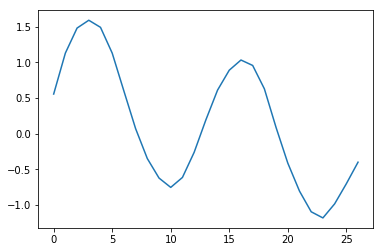

In [12]:
plt.plot(GMM_U)

In [13]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.7072190704642172


Local DMM on fine grid

In [14]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.6486560614508108
L = 0.003
rho = 0.6486544434140141
L = 0.004
rho = 0.6486532740202084
L = 0.005
rho = 0.648652550345681
L = 0.006
rho = 0.6486522694838268
L = 0.007
rho = 0.6486524285450411
L = 0.008
rho = 0.6486530246566128
L = 0.009000000000000001
rho = 0.6486540549626181
L = 0.010000000000000002
rho = 0.6486555166238179
L = 0.011000000000000003
rho = 0.648657406817553
L = 0.012000000000000004
rho = 0.6486597227376416
L = 0.013000000000000005
rho = 0.6486624615942779
L = 0.014000000000000005
rho = 0.6486656206139316
L = 0.015000000000000006
rho = 0.6486691970392489
L = 0.016000000000000007
rho = 0.6486731881289518
L = 0.017000000000000008
rho = 0.6486775911577428
L = 0.01800000000000001
rho = 0.6486824034162065
L = 0.01900000000000001
rho = 0.6486876222107123
L = 0.02000000000000001
rho = 0.6486932448633228
L = 0.02100000000000001
rho = 0.6486992687116963
L = 0.022000000000000013
rho = 0.6487056911089943
L = 0.023000000000000013
rho = 0.648712

L = 0.1440000000000001
rho = 0.6517895205278817
L = 0.1450000000000001
rho = 0.6518289320650684
L = 0.1460000000000001
rho = 0.651868509927828
L = 0.1470000000000001
rho = 0.6519082528590217
L = 0.1480000000000001
rho = 0.6519481596092553
L = 0.1490000000000001
rho = 0.6519882289368358
L = 0.1500000000000001
rho = 0.6520284596077307
L = 0.1510000000000001
rho = 0.6520688503955253
L = 0.1520000000000001
rho = 0.6521094000813791
L = 0.1530000000000001
rho = 0.6521501074539894
L = 0.1540000000000001
rho = 0.6521909713095435
L = 0.1550000000000001
rho = 0.6522319904516821
L = 0.1560000000000001
rho = 0.6522731636914575
L = 0.1570000000000001
rho = 0.6523144898472912
L = 0.1580000000000001
rho = 0.6523559677449351
L = 0.1590000000000001
rho = 0.6523975962174291
L = 0.16000000000000011
rho = 0.6524393741050637
L = 0.16100000000000012
rho = 0.6524813002553371
L = 0.16200000000000012
rho = 0.6525233735229184
L = 0.16300000000000012
rho = 0.652565592769604
L = 0.16400000000000012
rho = 0.652607

L = 0.2930000000000002
rho = 0.6589475219881521
L = 0.2940000000000002
rho = 0.6590013054683683
L = 0.2950000000000002
rho = 0.6590551339086504
L = 0.2960000000000002
rho = 0.6591090068304192
L = 0.2970000000000002
rho = 0.6591629237583163
L = 0.2980000000000002
rho = 0.6592168842201824
L = 0.2990000000000002
rho = 0.6592708877470382
L = 0.3000000000000002
rho = 0.6593249338730636
L = 0.3010000000000002
rho = 0.6593790221355782
L = 0.3020000000000002
rho = 0.6594331520750215
L = 0.3030000000000002
rho = 0.6594873232349334
L = 0.3040000000000002
rho = 0.659541535161933
L = 0.3050000000000002
rho = 0.6595957874057005
L = 0.3060000000000002
rho = 0.6596500795189584
L = 0.3070000000000002
rho = 0.6597044110574503
L = 0.3080000000000002
rho = 0.659758781579923
L = 0.3090000000000002
rho = 0.6598131906481064
L = 0.3100000000000002
rho = 0.6598676378266966
L = 0.3110000000000002
rho = 0.6599221226833337
L = 0.3120000000000002
rho = 0.6599766447885863
L = 0.3130000000000002
rho = 0.66003120371

L = 0.43300000000000033
rho = 0.6667423188091806
L = 0.43400000000000033
rho = 0.666798911883342
L = 0.43500000000000033
rho = 0.6668555066641374
L = 0.43600000000000033
rho = 0.6669121029688063
L = 0.43700000000000033
rho = 0.6669687006158467
L = 0.43800000000000033
rho = 0.6670252994250018
L = 0.43900000000000033
rho = 0.667081899217253
L = 0.44000000000000034
rho = 0.6671384998148125
L = 0.44100000000000034
rho = 0.6671951010411112
L = 0.44200000000000034
rho = 0.6672517027207941
L = 0.44300000000000034
rho = 0.6673083046797069
L = 0.44400000000000034
rho = 0.6673649067448911
L = 0.44500000000000034
rho = 0.6674215087445747
L = 0.44600000000000034
rho = 0.6674781105081627
L = 0.44700000000000034
rho = 0.6675347118662287
L = 0.44800000000000034
rho = 0.6675913126505078
L = 0.44900000000000034
rho = 0.6676479126938867
L = 0.45000000000000034
rho = 0.6677045118303966
L = 0.45100000000000035
rho = 0.6677611098952048
L = 0.45200000000000035
rho = 0.6678177067246053
L = 0.4530000000000003

L = 0.5740000000000004
rho = 0.6746716590268896
L = 0.5750000000000004
rho = 0.6747271438781658
L = 0.5760000000000004
rho = 0.6747826137476812
L = 0.5770000000000004
rho = 0.6748380685631733
L = 0.5780000000000004
rho = 0.6748935082528178
L = 0.5790000000000004
rho = 0.6749489327452245
L = 0.5800000000000004
rho = 0.6750043419694315
L = 0.5810000000000004
rho = 0.6750597358549048
L = 0.5820000000000004
rho = 0.675115114331533
L = 0.5830000000000004
rho = 0.6751704773296257
L = 0.5840000000000004
rho = 0.6752258247799109
L = 0.5850000000000004
rho = 0.6752811566135277
L = 0.5860000000000004
rho = 0.6753364727620278
L = 0.5870000000000004
rho = 0.6753917731573698
L = 0.5880000000000004
rho = 0.6754470577319186
L = 0.5890000000000004
rho = 0.6755023264184371
L = 0.5900000000000004
rho = 0.6755575791500898
L = 0.5910000000000004
rho = 0.6756128158604364
L = 0.5920000000000004
rho = 0.6756680364834265
L = 0.5930000000000004
rho = 0.6757232409534016
L = 0.5940000000000004
rho = 0.6757784292

L = 0.7090000000000005
rho = 0.6820024298560607
L = 0.7100000000000005
rho = 0.6820553776863637
L = 0.7110000000000005
rho = 0.6821083036944638
L = 0.7120000000000005
rho = 0.6821612078456792
L = 0.7130000000000005
rho = 0.6822140901054996
L = 0.7140000000000005
rho = 0.6822669504395863
L = 0.7150000000000005
rho = 0.6823197888137703
L = 0.7160000000000005
rho = 0.6823726051940494
L = 0.7170000000000005
rho = 0.6824253995465912
L = 0.7180000000000005
rho = 0.6824781718377293
L = 0.7190000000000005
rho = 0.6825309220339639
L = 0.7200000000000005
rho = 0.6825836501019596
L = 0.7210000000000005
rho = 0.6826363560085466
L = 0.7220000000000005
rho = 0.6826890397207159
L = 0.7230000000000005
rho = 0.682741701205624
L = 0.7240000000000005
rho = 0.6827943404305875
L = 0.7250000000000005
rho = 0.6828469573630847
L = 0.7260000000000005
rho = 0.682899551970752
L = 0.7270000000000005
rho = 0.6829521242213874
L = 0.7280000000000005
rho = 0.6830046740829462
L = 0.7290000000000005
rho = 0.68305720152

L = 0.8470000000000006
rho = 0.6890902714130521
L = 0.8480000000000006
rho = 0.689139943009722
L = 0.8490000000000006
rho = 0.689189589330295
L = 0.8500000000000006
rho = 0.6892392103580403
L = 0.8510000000000006
rho = 0.6892888060763297
L = 0.8520000000000006
rho = 0.6893383764686409
L = 0.8530000000000006
rho = 0.6893879215185545
L = 0.8540000000000006
rho = 0.6894374412097558
L = 0.8550000000000006
rho = 0.6894869355260334
L = 0.8560000000000006
rho = 0.6895364044512796
L = 0.8570000000000007
rho = 0.6895858479694909
L = 0.8580000000000007
rho = 0.6896352660647642
L = 0.8590000000000007
rho = 0.6896846587213022
L = 0.8600000000000007
rho = 0.6897340259234085
L = 0.8610000000000007
rho = 0.6897833676554895
L = 0.8620000000000007
rho = 0.6898326839020543
L = 0.8630000000000007
rho = 0.689881974647714
L = 0.8640000000000007
rho = 0.6899312398771812
L = 0.8650000000000007
rho = 0.6899804795752698
L = 0.8660000000000007
rho = 0.6900296937268962
L = 0.8670000000000007
rho = 0.690078882317

L = 0.9840000000000008
rho = 0.6956541905914742
L = 0.9850000000000008
rho = 0.6957002846798255
L = 0.9860000000000008
rho = 0.6957463520967431
L = 0.9870000000000008
rho = 0.6957923928381535
L = 0.9880000000000008
rho = 0.6958384069000629
L = 0.9890000000000008
rho = 0.6958843942785583
L = 0.9900000000000008
rho = 0.6959303549698068
L = 0.9910000000000008
rho = 0.6959762889700571
L = 0.9920000000000008
rho = 0.6960221962756358
L = 0.9930000000000008
rho = 0.6960680768829522
L = 0.9940000000000008
rho = 0.6961139307884937
L = 0.9950000000000008
rho = 0.6961597579888259
L = 0.9960000000000008
rho = 0.6962055584805968
L = 0.9970000000000008
rho = 0.6962513322605318
L = 0.9980000000000008
rho = 0.6962970793254356
L = 0.9990000000000008
rho = 0.6963427996721919
L = 1.0000000000000007
rho = 0.6963884932977635
======Section 2======
the 0 steps
rho = 0.6964341601991902
the 1 steps
rho = 0.6964198280888955
the 2 steps
rho = 0.6964055022810457
the 3 steps
rho = 0.696391182749785
the 4 steps
rho

the 186 steps
rho = 0.6938549627382147
the 187 steps
rho = 0.6938414709318564
the 188 steps
rho = 0.6938279823157781
the 189 steps
rho = 0.6938144968796895
the 190 steps
rho = 0.6938010146133478
the 191 steps
rho = 0.6937875355065565
the 192 steps
rho = 0.6937740595491643
the 193 steps
rho = 0.6937605867310672
the 194 steps
rho = 0.6937471170422057
the 195 steps
rho = 0.693733650472566
the 196 steps
rho = 0.693720187012179
the 197 steps
rho = 0.6937067266511223
the 198 steps
rho = 0.6936932693795161
the 199 steps
rho = 0.6936798151875256
the 200 steps
rho = 0.6936663640653608
the 201 steps
rho = 0.6936529160032744
the 202 steps
rho = 0.693639470991564
the 203 steps
rho = 0.693626029020569
the 204 steps
rho = 0.693612590080674
the 205 steps
rho = 0.6935991541623056
the 206 steps
rho = 0.6935857212559328
the 207 steps
rho = 0.6935722913520673
the 208 steps
rho = 0.6935588644412631
the 209 steps
rho = 0.6935454405141168
the 210 steps
rho = 0.6935320195612653
the 211 steps
rho = 0.69351860

the 392 steps
rho = 0.6911310111698067
the 393 steps
rho = 0.6911180113078753
the 394 steps
rho = 0.6911050132222787
the 395 steps
rho = 0.6910920169085821
the 396 steps
rho = 0.6910790223623691
the 397 steps
rho = 0.6910660295792381
the 398 steps
rho = 0.6910530385548029
the 399 steps
rho = 0.6910400492846958
the 400 steps
rho = 0.6910270617645606
the 401 steps
rho = 0.6910140759900607
the 402 steps
rho = 0.6910010919568735
the 403 steps
rho = 0.6909881096606925
the 404 steps
rho = 0.6909751290972269
the 405 steps
rho = 0.6909621502621999
the 406 steps
rho = 0.6909491731513515
the 407 steps
rho = 0.6909361977604368
the 408 steps
rho = 0.6909232240852263
the 409 steps
rho = 0.6909102521215059
the 410 steps
rho = 0.6908972818650738
the 411 steps
rho = 0.690884313311748
the 412 steps
rho = 0.6908713464573575
the 413 steps
rho = 0.6908583812977477
the 414 steps
rho = 0.6908454178287801
the 415 steps
rho = 0.6908324560463276
the 416 steps
rho = 0.690819495946281
the 417 steps
rho = 0.69080

the 600 steps
rho = 0.6884597509396378
the 601 steps
rho = 0.6884470442670986
the 602 steps
rho = 0.6884343387090617
the 603 steps
rho = 0.6884216342632857
the 604 steps
rho = 0.688408930927533
the 605 steps
rho = 0.6883962286995766
the 606 steps
rho = 0.6883835275771935
the 607 steps
rho = 0.6883708275581679
the 608 steps
rho = 0.6883581286402911
the 609 steps
rho = 0.6883454308213595
the 610 steps
rho = 0.6883327340991765
the 611 steps
rho = 0.6883200384715542
the 612 steps
rho = 0.6883073439363071
the 613 steps
rho = 0.6882946504912604
the 614 steps
rho = 0.6882819581342411
the 615 steps
rho = 0.6882692668630868
the 616 steps
rho = 0.6882565766756394
the 617 steps
rho = 0.6882438875697464
the 618 steps
rho = 0.6882311995432642
the 619 steps
rho = 0.6882185125940521
the 620 steps
rho = 0.6882058267199782
the 621 steps
rho = 0.6881931419189165
the 622 steps
rho = 0.6881804581887455
the 623 steps
rho = 0.688167775527353
the 624 steps
rho = 0.6881550939326291
the 625 steps
rho = 0.68814

the 742 steps
rho = 0.6866656108475166
the 743 steps
rho = 0.6866530427299272
the 744 steps
rho = 0.6866404754649079
the 745 steps
rho = 0.6866279090509577
the 746 steps
rho = 0.6866153434865772
the 747 steps
rho = 0.6866027787702725
the 748 steps
rho = 0.6865902149005535
the 749 steps
rho = 0.686577651875933
the 750 steps
rho = 0.6865650896949294
the 751 steps
rho = 0.6865525283560641
the 752 steps
rho = 0.6865399678578626
the 753 steps
rho = 0.6865274081988548
the 754 steps
rho = 0.6865148493775751
the 755 steps
rho = 0.6865022913925596
the 756 steps
rho = 0.6864897342423503
the 757 steps
rho = 0.6864771779254923
the 758 steps
rho = 0.6864646224405356
the 759 steps
rho = 0.6864520677860327
the 760 steps
rho = 0.686439513960541
the 761 steps
rho = 0.6864269609626213
the 762 steps
rho = 0.6864144087908381
the 763 steps
rho = 0.686401857443761
the 764 steps
rho = 0.6863893069199608
the 765 steps
rho = 0.6863767572180154
the 766 steps
rho = 0.6863642083365032
the 767 steps
rho = 0.686351

the 886 steps
rho = 0.684863911834806
the 887 steps
rho = 0.684851452798319
the 888 steps
rho = 0.6848389944343987
the 889 steps
rho = 0.6848265367420165
the 890 steps
rho = 0.6848140797201498
the 891 steps
rho = 0.6848016233677754
the 892 steps
rho = 0.6847891676838739
the 893 steps
rho = 0.6847767126674296
the 894 steps
rho = 0.6847642583174272
the 895 steps
rho = 0.6847518046328558
the 896 steps
rho = 0.684739351612707
the 897 steps
rho = 0.6847268992559743
the 898 steps
rho = 0.6847144475616539
the 899 steps
rho = 0.684701996528745
the 900 steps
rho = 0.6846895461562498
the 901 steps
rho = 0.6846770964431725
the 902 steps
rho = 0.6846646473885192
the 903 steps
rho = 0.6846521989912995
the 904 steps
rho = 0.6846397512505256
the 905 steps
rho = 0.6846273041652132
the 906 steps
rho = 0.6846148577343775
the 907 steps
rho = 0.6846024119570392
the 908 steps
rho = 0.6845899668322206
the 909 steps
rho = 0.6845775223589451
the 910 steps
rho = 0.6845650785362422
the 911 steps
rho = 0.6845526

the 1095 steps
rho = 0.6822732376706083
the 1096 steps
rho = 0.6822609004000734
the 1097 steps
rho = 0.6822485636365048
the 1098 steps
rho = 0.6822362273793093
the 1099 steps
rho = 0.6822238916278983
the 1100 steps
rho = 0.682211556381682
the 1101 steps
rho = 0.682199221640073
the 1102 steps
rho = 0.6821868874024867
the 1103 steps
rho = 0.6821745536683395
the 1104 steps
rho = 0.6821622204370482
the 1105 steps
rho = 0.6821498877080331
the 1106 steps
rho = 0.6821375554807144
the 1107 steps
rho = 0.6821252237545147
the 1108 steps
rho = 0.6821128925288588
the 1109 steps
rho = 0.6821005618031714
the 1110 steps
rho = 0.6820882315768806
the 1111 steps
rho = 0.6820759018494144
the 1112 steps
rho = 0.6820635726202036
the 1113 steps
rho = 0.6820512438886804
the 1114 steps
rho = 0.6820389156542774
the 1115 steps
rho = 0.6820265879164308
the 1116 steps
rho = 0.6820142606745765
the 1117 steps
rho = 0.6820019339281524
the 1118 steps
rho = 0.6819896076765991
the 1119 steps
rho = 0.681977281919357
the

the 1234 steps
rho = 0.6805629827738698
the 1235 steps
rho = 0.6805507109507539
the 1236 steps
rho = 0.6805384395663452
the 1237 steps
rho = 0.6805261686202438
the 1238 steps
rho = 0.6805138981120529
the 1239 steps
rho = 0.6805016280413766
the 1240 steps
rho = 0.6804893584078194
the 1241 steps
rho = 0.6804770892109878
the 1242 steps
rho = 0.6804648204504885
the 1243 steps
rho = 0.6804525521259311
the 1244 steps
rho = 0.6804402842369239
the 1245 steps
rho = 0.6804280167830794
the 1246 steps
rho = 0.6804157497640081
the 1247 steps
rho = 0.6804034831793241
the 1248 steps
rho = 0.6803912170286415
the 1249 steps
rho = 0.6803789513115758
the 1250 steps
rho = 0.6803666860277438
the 1251 steps
rho = 0.6803544211767631
the 1252 steps
rho = 0.6803421567582528
the 1253 steps
rho = 0.6803298927718335
the 1254 steps
rho = 0.680317629217126
the 1255 steps
rho = 0.6803053660937527
the 1256 steps
rho = 0.6802931034013381
the 1257 steps
rho = 0.6802808411395059
the 1258 steps
rho = 0.680268579307882
th

the 1378 steps
rho = 0.6788001822251574
the 1379 steps
rho = 0.6787879700116316
the 1380 steps
rho = 0.6787757581905419
the 1381 steps
rho = 0.678763546761637
the 1382 steps
rho = 0.678751335724668
the 1383 steps
rho = 0.6787391250793856
the 1384 steps
rho = 0.6787269148255421
the 1385 steps
rho = 0.6787147049628911
the 1386 steps
rho = 0.6787024954911851
the 1387 steps
rho = 0.67869028641018
the 1388 steps
rho = 0.6786780777196317
the 1389 steps
rho = 0.6786658694192953
the 1390 steps
rho = 0.6786536615089297
the 1391 steps
rho = 0.6786414539882922
the 1392 steps
rho = 0.6786292468571421
the 1393 steps
rho = 0.6786170401152394
the 1394 steps
rho = 0.678604833762345
the 1395 steps
rho = 0.6785926277982205
the 1396 steps
rho = 0.6785804222226282
the 1397 steps
rho = 0.6785682170353315
the 1398 steps
rho = 0.678556012236095
the 1399 steps
rho = 0.6785438078246834
the 1400 steps
rho = 0.6785316038008625
the 1401 steps
rho = 0.6785194001643997
the 1402 steps
rho = 0.6785071969150612
the 14

the 1515 steps
rho = 0.6771306715878324
the 1516 steps
rho = 0.6771185111486655
the 1517 steps
rho = 0.67710635107509
the 1518 steps
rho = 0.6770941913669593
the 1519 steps
rho = 0.6770820320241286
the 1520 steps
rho = 0.6770698730464534
the 1521 steps
rho = 0.6770577144337906
the 1522 steps
rho = 0.6770455561859966
the 1523 steps
rho = 0.677033398302929
the 1524 steps
rho = 0.6770212407844457
the 1525 steps
rho = 0.6770090836304066
the 1526 steps
rho = 0.6769969268406705
the 1527 steps
rho = 0.676984770415098
the 1528 steps
rho = 0.6769726143535486
the 1529 steps
rho = 0.6769604586558856
the 1530 steps
rho = 0.6769483033219706
the 1531 steps
rho = 0.6769361483516658
the 1532 steps
rho = 0.6769239937448353
the 1533 steps
rho = 0.6769118395013426
the 1534 steps
rho = 0.6768996856210526
the 1535 steps
rho = 0.6768875321038305
the 1536 steps
rho = 0.6768753789495427
the 1537 steps
rho = 0.6768632261580546
the 1538 steps
rho = 0.6768510737292357
the 1539 steps
rho = 0.6768389216629513
the 

the 1657 steps
rho = 0.675407491184883
the 1658 steps
rho = 0.6753953814872515
the 1659 steps
rho = 0.675383272140504
the 1660 steps
rho = 0.6753711631445755
the 1661 steps
rho = 0.6753590544994017
the 1662 steps
rho = 0.6753469462049183
the 1663 steps
rho = 0.6753348382610618
the 1664 steps
rho = 0.675322730667769
the 1665 steps
rho = 0.6753106234249776
the 1666 steps
rho = 0.675298516532625
the 1667 steps
rho = 0.6752864099906503
the 1668 steps
rho = 0.6752743037989921
the 1669 steps
rho = 0.6752621979575885
the 1670 steps
rho = 0.6752500924663807
the 1671 steps
rho = 0.675237987325309
the 1672 steps
rho = 0.6752258825343138
the 1673 steps
rho = 0.6752137780933354
the 1674 steps
rho = 0.6752016740023172
the 1675 steps
rho = 0.6751895702612003
the 1676 steps
rho = 0.675177466869927
the 1677 steps
rho = 0.6751653638284414
the 1678 steps
rho = 0.6751532611366864
the 1679 steps
rho = 0.6751411587946059
the 1680 steps
rho = 0.675129056802145
the 1681 steps
rho = 0.6751169551592483
the 168

the 1796 steps
rho = 0.6737275868773286
the 1797 steps
rho = 0.6737155255263017
the 1798 steps
rho = 0.6737034645213347
the 1799 steps
rho = 0.6736914038624197
the 1800 steps
rho = 0.67367934354955
the 1801 steps
rho = 0.6736672835827198
the 1802 steps
rho = 0.6736552239619231
the 1803 steps
rho = 0.6736431646871535
the 1804 steps
rho = 0.673631105758407
the 1805 steps
rho = 0.6736190471756779
the 1806 steps
rho = 0.673606988938962
the 1807 steps
rho = 0.6735949310482549
the 1808 steps
rho = 0.6735828735035533
the 1809 steps
rho = 0.6735708163048526
the 1810 steps
rho = 0.673558759452151
the 1811 steps
rho = 0.6735467029454449
the 1812 steps
rho = 0.6735346467847324
the 1813 steps
rho = 0.6735225909700101
the 1814 steps
rho = 0.6735105355012777
the 1815 steps
rho = 0.6734984803785339
the 1816 steps
rho = 0.673486425601776
the 1817 steps
rho = 0.6734743711710048
the 1818 steps
rho = 0.6734623170862192
the 1819 steps
rho = 0.6734502633474193
the 1820 steps
rho = 0.6734382099546057
the 18

the 1936 steps
rho = 0.6720423668780913
the 1937 steps
rho = 0.6720303540544436
the 1938 steps
rho = 0.6720183415789921
the 1939 steps
rho = 0.6720063294517731
the 1940 steps
rho = 0.6719943176728215
the 1941 steps
rho = 0.6719823062421738
the 1942 steps
rho = 0.6719702951598658
the 1943 steps
rho = 0.6719582844259347
the 1944 steps
rho = 0.6719462740404173
the 1945 steps
rho = 0.6719342640033501
the 1946 steps
rho = 0.6719222543147705
the 1947 steps
rho = 0.6719102449747166
the 1948 steps
rho = 0.6718982359832252
the 1949 steps
rho = 0.6718862273403355
the 1950 steps
rho = 0.6718742190460856
the 1951 steps
rho = 0.6718622111005135
the 1952 steps
rho = 0.6718502035036586
the 1953 steps
rho = 0.6718381962555597
the 1954 steps
rho = 0.6718261893562559
the 1955 steps
rho = 0.6718141828057873
the 1956 steps
rho = 0.6718021766041937
the 1957 steps
rho = 0.6717901707515143
the 1958 steps
rho = 0.6717781652477903
the 1959 steps
rho = 0.671766160093062
the 1960 steps
rho = 0.6717541552873703
t

the 2082 steps
rho = 0.6702922027002618
the 2083 steps
rho = 0.6702802412093706
the 2084 steps
rho = 0.6702682800742921
the 2085 steps
rho = 0.6702563192950949
the 2086 steps
rho = 0.6702443588718456
the 2087 steps
rho = 0.6702323988046117
the 2088 steps
rho = 0.670220439093461
the 2089 steps
rho = 0.6702084797384618
the 2090 steps
rho = 0.6701965207396814
the 2091 steps
rho = 0.6701845620971897
the 2092 steps
rho = 0.6701726038110525
the 2093 steps
rho = 0.6701606458813407
the 2094 steps
rho = 0.6701486883081219
the 2095 steps
rho = 0.6701367310914658
the 2096 steps
rho = 0.6701247742314407
the 2097 steps
rho = 0.6701128177281164
the 2098 steps
rho = 0.670100861581562
the 2099 steps
rho = 0.6700889057918479
the 2100 steps
rho = 0.6700769503590435
the 2101 steps
rho = 0.6700649952832181
the 2102 steps
rho = 0.6700530405644433
the 2103 steps
rho = 0.670041086202788
the 2104 steps
rho = 0.6700291321983244
the 2105 steps
rho = 0.6700171785511213
the 2106 steps
rho = 0.6700052252612505
the

the 2225 steps
rho = 0.6685853569451756
the 2226 steps
rho = 0.6685734470966291
the 2227 steps
rho = 0.6685615376151345
the 2228 steps
rho = 0.6685496285007817
the 2229 steps
rho = 0.6685377197536589
the 2230 steps
rho = 0.6685258113738554
the 2231 steps
rho = 0.6685139033614601
the 2232 steps
rho = 0.668501995716563
the 2233 steps
rho = 0.6684900884392526
the 2234 steps
rho = 0.6684781815296198
the 2235 steps
rho = 0.6684662749877539
the 2236 steps
rho = 0.6684543688137443
the 2237 steps
rho = 0.6684424630076815
the 2238 steps
rho = 0.668430557569655
the 2239 steps
rho = 0.6684186524997562
the 2240 steps
rho = 0.6684067477980737
the 2241 steps
rho = 0.6683948434647001
the 2242 steps
rho = 0.6683829394997237
the 2243 steps
rho = 0.6683710359032361
the 2244 steps
rho = 0.6683591326753298
the 2245 steps
rho = 0.6683472298160937
the 2246 steps
rho = 0.6683353273256195
the 2247 steps
rho = 0.6683234252039985
the 2248 steps
rho = 0.6683115234513218
the 2249 steps
rho = 0.6682996220676812
th

the 2369 steps
rho = 0.6668741632444585
the 2370 steps
rho = 0.6668623072224319
the 2371 steps
rho = 0.6668504515814025
the 2372 steps
rho = 0.6668385963214742
the 2373 steps
rho = 0.6668267414427508
the 2374 steps
rho = 0.6668148869453372
the 2375 steps
rho = 0.6668030328293373
the 2376 steps
rho = 0.6667911790948543
the 2377 steps
rho = 0.6667793257419945
the 2378 steps
rho = 0.6667674727708608
the 2379 steps
rho = 0.6667556201815589
the 2380 steps
rho = 0.6667437679741919
the 2381 steps
rho = 0.6667319161488663
the 2382 steps
rho = 0.666720064705686
the 2383 steps
rho = 0.666708213644756
the 2384 steps
rho = 0.6666963629661808
the 2385 steps
rho = 0.666684512670067
the 2386 steps
rho = 0.6666726627565179
the 2387 steps
rho = 0.6666608132256397
the 2388 steps
rho = 0.6666489640775382
the 2389 steps
rho = 0.6666371153123175
the 2390 steps
rho = 0.666625266930084
the 2391 steps
rho = 0.6666134189309431
the 2392 steps
rho = 0.6666015713149999
the 2393 steps
rho = 0.666589724082361
the 2

the 2579 steps
rho = 0.6643929238551232
the 2580 steps
rho = 0.6643811502381132
the 2581 steps
rho = 0.664369377025505
the 2582 steps
rho = 0.6643576042174161
the 2583 steps
rho = 0.6643458318139641
the 2584 steps
rho = 0.6643340598152674
the 2585 steps
rho = 0.6643222882214428
the 2586 steps
rho = 0.664310517032609
the 2587 steps
rho = 0.6642987462488831
the 2588 steps
rho = 0.6642869758703837
the 2589 steps
rho = 0.6642752058972283
the 2590 steps
rho = 0.6642634363295357
the 2591 steps
rho = 0.6642516671674228
the 2592 steps
rho = 0.6642398984110089
the 2593 steps
rho = 0.6642281300604118
the 2594 steps
rho = 0.6642163621157494
the 2595 steps
rho = 0.6642045945771401
the 2596 steps
rho = 0.6641928274447026
the 2597 steps
rho = 0.6641810607185548
the 2598 steps
rho = 0.664169294398815
the 2599 steps
rho = 0.664157528485602
the 2600 steps
rho = 0.6641457629790343
the 2601 steps
rho = 0.6641339978792304
the 2602 steps
rho = 0.6641222331863088
the 2603 steps
rho = 0.664110468900388
the 2

the 2722 steps
rho = 0.6627134593912449
the 2723 steps
rho = 0.6627017448187617
the 2724 steps
rho = 0.6626900306679263
the 2725 steps
rho = 0.6626783169388621
the 2726 steps
rho = 0.6626666036316928
the 2727 steps
rho = 0.6626548907465406
the 2728 steps
rho = 0.6626431782835295
the 2729 steps
rho = 0.6626314662427821
the 2730 steps
rho = 0.6626197546244226
the 2731 steps
rho = 0.6626080434285738
the 2732 steps
rho = 0.6625963326553598
the 2733 steps
rho = 0.6625846223049031
the 2734 steps
rho = 0.6625729123773278
the 2735 steps
rho = 0.6625612028727567
the 2736 steps
rho = 0.6625494937913142
the 2737 steps
rho = 0.6625377851331234
the 2738 steps
rho = 0.6625260768983079
the 2739 steps
rho = 0.6625143690869907
the 2740 steps
rho = 0.6625026616992968
the 2741 steps
rho = 0.6624909547353486
the 2742 steps
rho = 0.6624792481952704
the 2743 steps
rho = 0.6624675420791853
the 2744 steps
rho = 0.6624558363872178
the 2745 steps
rho = 0.6624441311194917
the 2746 steps
rho = 0.6624324262761305


the 2861 steps
rho = 0.661089232212003
the 2862 steps
rho = 0.6610775774420444
the 2863 steps
rho = 0.6610659231111109
the 2864 steps
rho = 0.6610542692193265
the 2865 steps
rho = 0.6610426157668194
the 2866 steps
rho = 0.661030962753716
the 2867 steps
rho = 0.661019310180143
the 2868 steps
rho = 0.6610076580462265
the 2869 steps
rho = 0.6609960063520937
the 2870 steps
rho = 0.660984355097871
the 2871 steps
rho = 0.6609727042836855
the 2872 steps
rho = 0.6609610539096641
the 2873 steps
rho = 0.6609494039759326
the 2874 steps
rho = 0.6609377544826185
the 2875 steps
rho = 0.6609261054298485
the 2876 steps
rho = 0.6609144568177492
the 2877 steps
rho = 0.6609028086464477
the 2878 steps
rho = 0.6608911609160705
the 2879 steps
rho = 0.6608795136267447
the 2880 steps
rho = 0.6608678667785975
the 2881 steps
rho = 0.6608562203717556
the 2882 steps
rho = 0.6608445744063453
the 2883 steps
rho = 0.6608329288824939
the 2884 steps
rho = 0.660821283800329
the 2885 steps
rho = 0.660809639159976
the 28

the 3001 steps
rho = 0.6594618930395455
the 3002 steps
rho = 0.6594503009720821
the 3003 steps
rho = 0.6594387093615208
the 3004 steps
rho = 0.659427118207989
the 3005 steps
rho = 0.6594155275116164
the 3006 steps
rho = 0.6594039372725314
the 3007 steps
rho = 0.6593923474908628
the 3008 steps
rho = 0.659380758166739
the 3009 steps
rho = 0.6593691693002885
the 3010 steps
rho = 0.6593575808916408
the 3011 steps
rho = 0.6593459929409233
the 3012 steps
rho = 0.6593344054482662
the 3013 steps
rho = 0.6593228184137969
the 3014 steps
rho = 0.6593112318376455
the 3015 steps
rho = 0.6592996457199398
the 3016 steps
rho = 0.6592880600608088
the 3017 steps
rho = 0.6592764748603808
the 3018 steps
rho = 0.659264890118786
the 3019 steps
rho = 0.6592533058361512
the 3020 steps
rho = 0.6592417220126063
the 3021 steps
rho = 0.6592301386482805
the 3022 steps
rho = 0.6592185557433021
the 3023 steps
rho = 0.6592069732977999
the 3024 steps
rho = 0.6591953913119029
the 3025 steps
rho = 0.6591838097857398
the

the 3197 steps
rho = 0.6571987387060576
the 3198 steps
rho = 0.6571872386601006
the 3199 steps
rho = 0.657175739096408
the 3200 steps
rho = 0.6571642400151105
the 3201 steps
rho = 0.6571527414163375
the 3202 steps
rho = 0.6571412433002193
the 3203 steps
rho = 0.6571297456668854
the 3204 steps
rho = 0.6571182485164658
the 3205 steps
rho = 0.6571067518490907
the 3206 steps
rho = 0.6570952556648909
the 3207 steps
rho = 0.6570837599639945
the 3208 steps
rho = 0.6570722647465321
the 3209 steps
rho = 0.6570607700126346
the 3210 steps
rho = 0.6570492757624311
the 3211 steps
rho = 0.6570377819960517
the 3212 steps
rho = 0.6570262887136267
the 3213 steps
rho = 0.6570147959152854
the 3214 steps
rho = 0.6570033036011586
the 3215 steps
rho = 0.6569918117713762
the 3216 steps
rho = 0.6569803204260669
the 3217 steps
rho = 0.6569688295653618
the 3218 steps
rho = 0.6569573391893911
the 3219 steps
rho = 0.6569458492982837
the 3220 steps
rho = 0.6569343598921712
the 3221 steps
rho = 0.6569228709711818
t

the 3383 steps
rho = 0.6550681647296072
the 3384 steps
rho = 0.6550567566222318
the 3385 steps
rho = 0.6550453490213121
the 3386 steps
rho = 0.6550339419269777
the 3387 steps
rho = 0.6550225353393591
the 3388 steps
rho = 0.6550111292585858
the 3389 steps
rho = 0.6549997236847884
the 3390 steps
rho = 0.6549883186180969
the 3391 steps
rho = 0.6549769140586408
the 3392 steps
rho = 0.6549655100065506
the 3393 steps
rho = 0.6549541064619563
the 3394 steps
rho = 0.6549427034249874
the 3395 steps
rho = 0.6549313008957746
the 3396 steps
rho = 0.6549198988744472
the 3397 steps
rho = 0.6549084973611363
the 3398 steps
rho = 0.6548970963559709
the 3399 steps
rho = 0.6548856958590816
the 3400 steps
rho = 0.6548742958705981
the 3401 steps
rho = 0.6548628963906508
the 3402 steps
rho = 0.6548514974193691
the 3403 steps
rho = 0.654840098956884
the 3404 steps
rho = 0.6548287010033246
the 3405 steps
rho = 0.654817303558821
the 3406 steps
rho = 0.6548059066235034
the 3407 steps
rho = 0.6547945101975021
th

the 3574 steps
rho = 0.6528985543886308
the 3575 steps
rho = 0.6528872453710608
the 3576 steps
rho = 0.6528759368847352
the 3577 steps
rho = 0.6528646289297824
the 3578 steps
rho = 0.6528533215063325
the 3579 steps
rho = 0.6528420146145144
the 3580 steps
rho = 0.6528307082544587
the 3581 steps
rho = 0.6528194024262935
the 3582 steps
rho = 0.6528080971301494
the 3583 steps
rho = 0.6527967923661542
the 3584 steps
rho = 0.6527854881344383
the 3585 steps
rho = 0.6527741844351312
the 3586 steps
rho = 0.6527628812683617
the 3587 steps
rho = 0.6527515786342598
the 3588 steps
rho = 0.6527402765329547
the 3589 steps
rho = 0.6527289749645755
the 3590 steps
rho = 0.652717673929251
the 3591 steps
rho = 0.6527063734271117
the 3592 steps
rho = 0.6526950734582863
the 3593 steps
rho = 0.6526837740229047
the 3594 steps
rho = 0.6526724751210956
the 3595 steps
rho = 0.6526611767529885
the 3596 steps
rho = 0.6526498789187125
the 3597 steps
rho = 0.6526385816183974
the 3598 steps
rho = 0.6526272848521727
t

the 3769 steps
rho = 0.650703501615668
the 3770 steps
rho = 0.6506922986319911
the 3771 steps
rho = 0.6506810962046878
the 3772 steps
rho = 0.6506698943338864
the 3773 steps
rho = 0.6506586930197154
the 3774 steps
rho = 0.6506474922623027
the 3775 steps
rho = 0.6506362920617764
the 3776 steps
rho = 0.6506250924182649
the 3777 steps
rho = 0.6506138933318967
the 3778 steps
rho = 0.6506026948027995
the 3779 steps
rho = 0.650591496831102
the 3780 steps
rho = 0.6505802994169317
the 3781 steps
rho = 0.6505691025604172
the 3782 steps
rho = 0.6505579062616866
the 3783 steps
rho = 0.6505467105208681
the 3784 steps
rho = 0.6505355153380896
the 3785 steps
rho = 0.6505243207134799
the 3786 steps
rho = 0.650513126647166
the 3787 steps
rho = 0.6505019331392774
the 3788 steps
rho = 0.6504907401899412
the 3789 steps
rho = 0.6504795477992864
the 3790 steps
rho = 0.65046835596744
the 3791 steps
rho = 0.6504571646945306
the 3792 steps
rho = 0.6504459739806865
the 3793 steps
rho = 0.6504347838260354
the 3

the 3959 steps
rho = 0.6485850682966353
the 3960 steps
rho = 0.6485739733177844
the 3961 steps
rho = 0.648562878919531
the 3962 steps
rho = 0.6485517851020016
the 3963 steps
rho = 0.6485406918653225
the 3964 steps
rho = 0.6485295992096206
the 3965 steps
rho = 0.6485185071350226
the 3966 steps
rho = 0.6485074156416555
the 3967 steps
rho = 0.6484963247296451
the 3968 steps
rho = 0.6484852343991186
the 3969 steps
rho = 0.6484741446502023
the 3970 steps
rho = 0.6484630554830233
the 3971 steps
rho = 0.6484519668977077
the 3972 steps
rho = 0.6484408788943824
the 3973 steps
rho = 0.6484297914731738
the 3974 steps
rho = 0.6484187046342087
the 3975 steps
rho = 0.6484076183776132
the 3976 steps
rho = 0.648396532703514
the 3977 steps
rho = 0.6483854476120382
the 3978 steps
rho = 0.6483743631033114
the 3979 steps
rho = 0.6483632791774611
the 3980 steps
rho = 0.6483521958346129
the 3981 steps
rho = 0.6483411130748937
the 3982 steps
rho = 0.64833003089843
the 3983 steps
rho = 0.6483189493053482
the 

the 4154 steps
rho = 0.6464326830044692
the 4155 steps
rho = 0.6464217036263595
the 4156 steps
rho = 0.6464107248533622
the 4157 steps
rho = 0.6463997466856021
the 4158 steps
rho = 0.6463887691232042
the 4159 steps
rho = 0.6463777921662935
the 4160 steps
rho = 0.646366815814993
the 4161 steps
rho = 0.6463558400694294
the 4162 steps
rho = 0.6463448649297261
the 4163 steps
rho = 0.6463338903960075
the 4164 steps
rho = 0.6463229164683997
the 4165 steps
rho = 0.6463119431470257
the 4166 steps
rho = 0.646300970432011
the 4167 steps
rho = 0.6462899983234801
the 4168 steps
rho = 0.6462790268215568
the 4169 steps
rho = 0.6462680559263662
the 4170 steps
rho = 0.6462570856380337
the 4171 steps
rho = 0.6462461159566825
the 4172 steps
rho = 0.6462351468824375
the 4173 steps
rho = 0.6462241784154232
the 4174 steps
rho = 0.6462132105557647
the 4175 steps
rho = 0.6462022433035857
the 4176 steps
rho = 0.6461912766590112
the 4177 steps
rho = 0.6461803106221654
the 4178 steps
rho = 0.6461693451931729
th

the 4353 steps
rho = 0.6442598686631612
the 4354 steps
rho = 0.6442490121438912
the 4355 steps
rho = 0.6442381562543134
the 4356 steps
rho = 0.6442273009945509
the 4357 steps
rho = 0.6442164463647251
the 4358 steps
rho = 0.6442055923649591
the 4359 steps
rho = 0.6441947389953748
the 4360 steps
rho = 0.6441838862560939
the 4361 steps
rho = 0.644173034147239
the 4362 steps
rho = 0.6441621826689327
the 4363 steps
rho = 0.6441513318212964
the 4364 steps
rho = 0.6441404816044527
the 4365 steps
rho = 0.6441296320185237
the 4366 steps
rho = 0.6441187830636312
the 4367 steps
rho = 0.6441079347398976
the 4368 steps
rho = 0.644097087047445
the 4369 steps
rho = 0.6440862399863957
the 4370 steps
rho = 0.6440753935568717
the 4371 steps
rho = 0.6440645477589942
the 4372 steps
rho = 0.6440537025928866
the 4373 steps
rho = 0.6440428580586702
the 4374 steps
rho = 0.644032014156467
the 4375 steps
rho = 0.6440211708863989
the 4376 steps
rho = 0.6440103282485882
the 4377 steps
rho = 0.6439994862431575
the

the 4492 steps
rho = 0.6427569052135648
the 4493 steps
rho = 0.6427461373881957
the 4494 steps
rho = 0.6427353702093813
the 4495 steps
rho = 0.6427246036772418
the 4496 steps
rho = 0.6427138377918982
the 4497 steps
rho = 0.6427030725534696
the 4498 steps
rho = 0.6426923079620765
the 4499 steps
rho = 0.6426815440178396
the 4500 steps
rho = 0.6426707807208787
the 4501 steps
rho = 0.6426600180713145
the 4502 steps
rho = 0.6426492560692669
the 4503 steps
rho = 0.6426384947148562
the 4504 steps
rho = 0.6426277340082023
the 4505 steps
rho = 0.6426169739494262
the 4506 steps
rho = 0.6426062145386466
the 4507 steps
rho = 0.6425954557759846
the 4508 steps
rho = 0.6425846976615599
the 4509 steps
rho = 0.6425739401954929
the 4510 steps
rho = 0.6425631833779041
the 4511 steps
rho = 0.6425524272089125
the 4512 steps
rho = 0.6425416716886394
the 4513 steps
rho = 0.6425309168172031
the 4514 steps
rho = 0.6425201625947254
the 4515 steps
rho = 0.6425094090213255
the 4516 steps
rho = 0.6424986560971232


the 4631 steps
rho = 0.6412664310575691
the 4632 steps
rho = 0.6412557542504136
the 4633 steps
rho = 0.6412450781063864
the 4634 steps
rho = 0.641234402625606
the 4635 steps
rho = 0.6412237278081903
the 4636 steps
rho = 0.6412130536542567
the 4637 steps
rho = 0.6412023801639242
the 4638 steps
rho = 0.6411917073373101
the 4639 steps
rho = 0.6411810351745328
the 4640 steps
rho = 0.641170363675711
the 4641 steps
rho = 0.6411596928409619
the 4642 steps
rho = 0.6411490226704029
the 4643 steps
rho = 0.6411383531641524
the 4644 steps
rho = 0.6411276843223292
the 4645 steps
rho = 0.6411170161450505
the 4646 steps
rho = 0.6411063486324342
the 4647 steps
rho = 0.6410956817845983
the 4648 steps
rho = 0.6410850156016608
the 4649 steps
rho = 0.641074350083739
the 4650 steps
rho = 0.6410636852309516
the 4651 steps
rho = 0.6410530210434159
the 4652 steps
rho = 0.6410423575212498
the 4653 steps
rho = 0.6410316946645706
the 4654 steps
rho = 0.6410210324734968
the 4655 steps
rho = 0.6410103709481464
the

the 4771 steps
rho = 0.6397781828962669
the 4772 steps
rho = 0.6397676000685935
the 4773 steps
rho = 0.6397570179204152
the 4774 steps
rho = 0.6397464364518468
the 4775 steps
rho = 0.6397358556630044
the 4776 steps
rho = 0.6397252755540043
the 4777 steps
rho = 0.639714696124961
the 4778 steps
rho = 0.6397041173759903
the 4779 steps
rho = 0.6396935393072082
the 4780 steps
rho = 0.6396829619187298
the 4781 steps
rho = 0.6396723852106702
the 4782 steps
rho = 0.6396618091831461
the 4783 steps
rho = 0.6396512338362721
the 4784 steps
rho = 0.6396406591701637
the 4785 steps
rho = 0.6396300851849366
the 4786 steps
rho = 0.639619511880706
the 4787 steps
rho = 0.6396089392575871
the 4788 steps
rho = 0.6395983673156956
the 4789 steps
rho = 0.6395877960551472
the 4790 steps
rho = 0.6395772254760564
the 4791 steps
rho = 0.6395666555785385
the 4792 steps
rho = 0.63955608636271
the 4793 steps
rho = 0.6395455178286847
the 4794 steps
rho = 0.6395349499765788
the 4795 steps
rho = 0.6395243828065074
the 

the 4917 steps
rho = 0.6382403409107626
the 4918 steps
rho = 0.6382298585035039
the 4919 steps
rho = 0.6382193767924164
the 4920 steps
rho = 0.6382088957776124
the 4921 steps
rho = 0.6381984154592054
the 4922 steps
rho = 0.6381879358373067
the 4923 steps
rho = 0.6381774569120304
the 4924 steps
rho = 0.6381669786834888
the 4925 steps
rho = 0.6381565011517943
the 4926 steps
rho = 0.6381460243170595
the 4927 steps
rho = 0.6381355481793967
the 4928 steps
rho = 0.6381250727389194
the 4929 steps
rho = 0.638114597995739
the 4930 steps
rho = 0.6381041239499685
the 4931 steps
rho = 0.6380936506017211
the 4932 steps
rho = 0.638083177951108
the 4933 steps
rho = 0.6380727059982426
the 4934 steps
rho = 0.6380622347432373
the 4935 steps
rho = 0.6380517641862038
the 4936 steps
rho = 0.6380412943272552
the 4937 steps
rho = 0.6380308251665036
the 4938 steps
rho = 0.6380203567040612
the 4939 steps
rho = 0.6380098889400408
the 4940 steps
rho = 0.6379994218745544
the 4941 steps
rho = 0.637988955507714
the

the 5062 steps
rho = 0.6367277156045177
the 5063 steps
rho = 0.636717335308226
the 5064 steps
rho = 0.6367069557242228
the 5065 steps
rho = 0.6366965768526179
the 5066 steps
rho = 0.6366861986935216
the 5067 steps
rho = 0.6366758212470434
the 5068 steps
rho = 0.6366654445132918
the 5069 steps
rho = 0.6366550684923764
the 5070 steps
rho = 0.6366446931844068
the 5071 steps
rho = 0.6366343185894927
the 5072 steps
rho = 0.6366239447077429
the 5073 steps
rho = 0.6366135715392668
the 5074 steps
rho = 0.6366031990841737
the 5075 steps
rho = 0.6365928273425739
the 5076 steps
rho = 0.6365824563145752
the 5077 steps
rho = 0.636572086000287
the 5078 steps
rho = 0.6365617163998192
the 5079 steps
rho = 0.6365513475132799
the 5080 steps
rho = 0.6365409793407798
the 5081 steps
rho = 0.6365306118824265
the 5082 steps
rho = 0.6365202451383308
the 5083 steps
rho = 0.6365098791085997
the 5084 steps
rho = 0.6364995137933436
the 5085 steps
rho = 0.6364891491926714
the 5086 steps
rho = 0.6364787853066919
th

the 5202 steps
rho = 0.6352814533382143
the 5203 steps
rho = 0.635271173817003
the 5204 steps
rho = 0.635260895023173
the 5205 steps
rho = 0.6352506169568307
the 5206 steps
rho = 0.6352403396180816
the 5207 steps
rho = 0.6352300630070316
the 5208 steps
rho = 0.6352197871237867
the 5209 steps
rho = 0.6352095119684528
the 5210 steps
rho = 0.6351992375411362
the 5211 steps
rho = 0.6351889638419425
the 5212 steps
rho = 0.6351786908709771
the 5213 steps
rho = 0.6351684186283466
the 5214 steps
rho = 0.6351581471141559
the 5215 steps
rho = 0.6351478763285114
the 5216 steps
rho = 0.6351376062715188
the 5217 steps
rho = 0.6351273369432834
the 5218 steps
rho = 0.6351170683439117
the 5219 steps
rho = 0.6351068004735074
the 5220 steps
rho = 0.6350965333321783
the 5221 steps
rho = 0.6350862669200293
the 5222 steps
rho = 0.6350760012371655
the 5223 steps
rho = 0.6350657362836928
the 5224 steps
rho = 0.6350554720597164
the 5225 steps
rho = 0.635045208565342
the 5226 steps
rho = 0.6350349458006759
the

the 5341 steps
rho = 0.6338596222365611
the 5342 steps
rho = 0.6338494448262971
the 5343 steps
rho = 0.6338392681578896
the 5344 steps
rho = 0.6338290922314396
the 5345 steps
rho = 0.6338189170470498
the 5346 steps
rho = 0.6338087426048218
the 5347 steps
rho = 0.6337985689048589
the 5348 steps
rho = 0.6337883959472621
the 5349 steps
rho = 0.6337782237321341
the 5350 steps
rho = 0.6337680522595758
the 5351 steps
rho = 0.63375788152969
the 5352 steps
rho = 0.6337477115425788
the 5353 steps
rho = 0.6337375422983433
the 5354 steps
rho = 0.6337273737970861
the 5355 steps
rho = 0.6337172060389089
the 5356 steps
rho = 0.6337070390239133
the 5357 steps
rho = 0.6336968727522012
the 5358 steps
rho = 0.6336867072238735
the 5359 steps
rho = 0.6336765424390336
the 5360 steps
rho = 0.6336663783977818
the 5361 steps
rho = 0.6336562151002207
the 5362 steps
rho = 0.6336460525464516
the 5363 steps
rho = 0.6336358907365752
the 5364 steps
rho = 0.6336257296706949
the 5365 steps
rho = 0.6336155693489106
th

the 5482 steps
rho = 0.6324319757551523
the 5483 steps
rho = 0.6324219039411786
the 5484 steps
rho = 0.6324118328831672
the 5485 steps
rho = 0.632401762581215
the 5486 steps
rho = 0.6323916930354212
the 5487 steps
rho = 0.6323816242458826
the 5488 steps
rho = 0.6323715562126971
the 5489 steps
rho = 0.632361488935962
the 5490 steps
rho = 0.6323514224157764
the 5491 steps
rho = 0.6323413566522362
the 5492 steps
rho = 0.6323312916454399
the 5493 steps
rho = 0.6323212273954847
the 5494 steps
rho = 0.6323111639024684
the 5495 steps
rho = 0.6323011011664885
the 5496 steps
rho = 0.6322910391876422
the 5497 steps
rho = 0.6322809779660271
the 5498 steps
rho = 0.6322709175017406
the 5499 steps
rho = 0.6322608577948802
the 5500 steps
rho = 0.6322507988455434
the 5501 steps
rho = 0.6322407406538266
the 5502 steps
rho = 0.6322306832198279
the 5503 steps
rho = 0.6322206265436443
the 5504 steps
rho = 0.6322105706253731
the 5505 steps
rho = 0.6322005154651116
the 5506 steps
rho = 0.632190461062956
the

the 5626 steps
rho = 0.6309894650342612
the 5627 steps
rho = 0.6309795030698312
the 5628 steps
rho = 0.6309695418751052
the 5629 steps
rho = 0.6309595814501759
the 5630 steps
rho = 0.6309496217951361
the 5631 steps
rho = 0.6309396629100793
the 5632 steps
rho = 0.6309297047950972
the 5633 steps
rho = 0.6309197474502839
the 5634 steps
rho = 0.6309097908757311
the 5635 steps
rho = 0.6308998350715322
the 5636 steps
rho = 0.6308898800377792
the 5637 steps
rho = 0.6308799257745654
the 5638 steps
rho = 0.6308699722819827
the 5639 steps
rho = 0.6308600195601242
the 5640 steps
rho = 0.6308500676090822
the 5641 steps
rho = 0.6308401164289498
the 5642 steps
rho = 0.6308301660198182
the 5643 steps
rho = 0.6308202163817809
the 5644 steps
rho = 0.6308102675149294
the 5645 steps
rho = 0.6308003194193574
the 5646 steps
rho = 0.6307903720951558
the 5647 steps
rho = 0.6307804255424172
the 5648 steps
rho = 0.6307704797612348
the 5649 steps
rho = 0.6307605347516997
the 5650 steps
rho = 0.6307505905139047


the 5772 steps
rho = 0.6295432120914386
the 5773 steps
rho = 0.6295333634687099
the 5774 steps
rho = 0.6295235156288609
the 5775 steps
rho = 0.6295136685719779
the 5776 steps
rho = 0.6295038222981486
the 5777 steps
rho = 0.6294939768074607
the 5778 steps
rho = 0.6294841321000005
the 5779 steps
rho = 0.6294742881758572
the 5780 steps
rho = 0.6294644450351163
the 5781 steps
rho = 0.6294546026778656
the 5782 steps
rho = 0.6294447611041926
the 5783 steps
rho = 0.6294349203141837
the 5784 steps
rho = 0.6294250803079264
the 5785 steps
rho = 0.6294152410855077
the 5786 steps
rho = 0.6294054026470148
the 5787 steps
rho = 0.6293955649925341
the 5788 steps
rho = 0.6293857281221533
the 5789 steps
rho = 0.6293758920359587
the 5790 steps
rho = 0.6293660567340369
the 5791 steps
rho = 0.6293562222164757
the 5792 steps
rho = 0.629346388483361
the 5793 steps
rho = 0.6293365555347799
the 5794 steps
rho = 0.6293267233708185
the 5795 steps
rho = 0.6293168919915645
the 5796 steps
rho = 0.6293070613971035
t

the 5917 steps
rho = 0.6281233778547729
the 5918 steps
rho = 0.6281136436422613
the 5919 steps
rho = 0.6281039102248825
the 5920 steps
rho = 0.6280941776027188
the 5921 steps
rho = 0.628084445775851
the 5922 steps
rho = 0.6280747147443606
the 5923 steps
rho = 0.6280649845083287
the 5924 steps
rho = 0.6280552550678364
the 5925 steps
rho = 0.6280455264229653
the 5926 steps
rho = 0.6280357985737965
the 5927 steps
rho = 0.6280260715204116
the 5928 steps
rho = 0.6280163452628909
the 5929 steps
rho = 0.6280066198013164
the 5930 steps
rho = 0.6279968951357678
the 5931 steps
rho = 0.6279871712663282
the 5932 steps
rho = 0.6279774481930761
the 5933 steps
rho = 0.627967725916094
the 5934 steps
rho = 0.6279580044354622
the 5935 steps
rho = 0.6279482837512618
the 5936 steps
rho = 0.6279385638635729
the 5937 steps
rho = 0.6279288447724771
the 5938 steps
rho = 0.6279191264780543
the 5939 steps
rho = 0.6279094089803854
the 5940 steps
rho = 0.6278996922795514
the 5941 steps
rho = 0.6278899763756327
th

the 6065 steps
rho = 0.6266914061423772
the 6066 steps
rho = 0.6266817904723433
the 6067 steps
rho = 0.626672175609016
the 6068 steps
rho = 0.6266625615524697
the 6069 steps
rho = 0.6266529483027795
the 6070 steps
rho = 0.6266433358600197
the 6071 steps
rho = 0.6266337242242654
the 6072 steps
rho = 0.6266241133955911
the 6073 steps
rho = 0.6266145033740715
the 6074 steps
rho = 0.6266048941597808
the 6075 steps
rho = 0.6265952857527934
the 6076 steps
rho = 0.6265856781531841
the 6077 steps
rho = 0.626576071361027
the 6078 steps
rho = 0.6265664653763963
the 6079 steps
rho = 0.6265568601993668
the 6080 steps
rho = 0.6265472558300119
the 6081 steps
rho = 0.6265376522684071
the 6082 steps
rho = 0.6265280495146257
the 6083 steps
rho = 0.6265184475687416
the 6084 steps
rho = 0.6265088464308294
the 6085 steps
rho = 0.6264992461009624
the 6086 steps
rho = 0.6264896465792156
the 6087 steps
rho = 0.6264800478656617
the 6088 steps
rho = 0.6264704499603752
the 6089 steps
rho = 0.6264608528634305
th

the 6210 steps
rho = 0.6253055923859243
the 6211 steps
rho = 0.6252960944454771
the 6212 steps
rho = 0.6252865973220811
the 6213 steps
rho = 0.6252771010158031
the 6214 steps
rho = 0.6252676055267118
the 6215 steps
rho = 0.6252581108548739
the 6216 steps
rho = 0.625248617000358
the 6217 steps
rho = 0.6252391239632307
the 6218 steps
rho = 0.6252296317435604
the 6219 steps
rho = 0.6252201403414138
the 6220 steps
rho = 0.6252106497568585
the 6221 steps
rho = 0.6252011599899618
the 6222 steps
rho = 0.6251916710407912
the 6223 steps
rho = 0.6251821829094137
the 6224 steps
rho = 0.6251726955958968
the 6225 steps
rho = 0.6251632091003074
the 6226 steps
rho = 0.6251537234227122
the 6227 steps
rho = 0.6251442385631788
the 6228 steps
rho = 0.6251347545217745
the 6229 steps
rho = 0.6251252712985654
the 6230 steps
rho = 0.6251157888936186
the 6231 steps
rho = 0.6251063073070017
the 6232 steps
rho = 0.62509682653878
the 6233 steps
rho = 0.6250873465890218
the 6234 steps
rho = 0.6250778674577924
the

the 6350 steps
rho = 0.623983860164407
the 6351 steps
rho = 0.6239744772472534
the 6352 steps
rho = 0.6239650951561325
the 6353 steps
rho = 0.6239557138911047
the 6354 steps
rho = 0.6239463334522317
the 6355 steps
rho = 0.6239369538395723
the 6356 steps
rho = 0.6239275750531872
the 6357 steps
rho = 0.6239181970931368
the 6358 steps
rho = 0.6239088199594811
the 6359 steps
rho = 0.6238994436522804
the 6360 steps
rho = 0.6238900681715946
the 6361 steps
rho = 0.623880693517484
the 6362 steps
rho = 0.6238713196900082
the 6363 steps
rho = 0.6238619466892272
the 6364 steps
rho = 0.6238525745152008
the 6365 steps
rho = 0.623843203167989
the 6366 steps
rho = 0.6238338326476516
the 6367 steps
rho = 0.6238244629542479
the 6368 steps
rho = 0.6238150940878379
the 6369 steps
rho = 0.6238057260484808
the 6370 steps
rho = 0.6237963588362369
the 6371 steps
rho = 0.6237869924511648
the 6372 steps
rho = 0.6237776268933244
the 6373 steps
rho = 0.623768262162775
the 6374 steps
rho = 0.6237588982595754
the 

the 6490 steps
rho = 0.6226783152824326
the 6491 steps
rho = 0.6226690485735792
the 6492 steps
rho = 0.6226597826986868
the 6493 steps
rho = 0.6226505176578087
the 6494 steps
rho = 0.6226412534509977
the 6495 steps
rho = 0.6226319900783059
the 6496 steps
rho = 0.6226227275397861
the 6497 steps
rho = 0.6226134658354906
the 6498 steps
rho = 0.6226042049654726
the 6499 steps
rho = 0.6225949449297831
the 6500 steps
rho = 0.6225856857284756
the 6501 steps
rho = 0.6225764273616019
the 6502 steps
rho = 0.6225671698292139
the 6503 steps
rho = 0.6225579131313637
the 6504 steps
rho = 0.6225486572681042
the 6505 steps
rho = 0.6225394022394865
the 6506 steps
rho = 0.6225301480455627
the 6507 steps
rho = 0.622520894686385
the 6508 steps
rho = 0.6225116421620053
the 6509 steps
rho = 0.6225023904724755
the 6510 steps
rho = 0.6224931396178465
the 6511 steps
rho = 0.6224838895981708
the 6512 steps
rho = 0.6224746404134992
the 6513 steps
rho = 0.6224653920638847
the 6514 steps
rho = 0.6224561445493773
t

the 6627 steps
rho = 0.6214165666408223
the 6628 steps
rho = 0.6214074146515131
the 6629 steps
rho = 0.6213982635028469
the 6630 steps
rho = 0.6213891131948688
the 6631 steps
rho = 0.6213799637276232
the 6632 steps
rho = 0.6213708151011549
the 6633 steps
rho = 0.6213616673155081
the 6634 steps
rho = 0.6213525203707281
the 6635 steps
rho = 0.6213433742668585
the 6636 steps
rho = 0.6213342290039439
the 6637 steps
rho = 0.6213250845820285
the 6638 steps
rho = 0.6213159410011573
the 6639 steps
rho = 0.6213067982613737
the 6640 steps
rho = 0.6212976563627218
the 6641 steps
rho = 0.6212885153052463
the 6642 steps
rho = 0.6212793750889908
the 6643 steps
rho = 0.6212702357139994
the 6644 steps
rho = 0.6212610971803159
the 6645 steps
rho = 0.6212519594879838
the 6646 steps
rho = 0.6212428226370476
the 6647 steps
rho = 0.6212336866275501
the 6648 steps
rho = 0.621224551459536
the 6649 steps
rho = 0.6212154171330485
the 6650 steps
rho = 0.6212062836481309
the 6651 steps
rho = 0.6211971510048269
t

the 6764 steps
rho = 0.6201705934483857
the 6765 steps
rho = 0.6201615570187533
the 6766 steps
rho = 0.6201525214353316
the 6767 steps
rho = 0.6201434866981573
the 6768 steps
rho = 0.6201344528072659
the 6769 steps
rho = 0.6201254197626951
the 6770 steps
rho = 0.62011638756448
the 6771 steps
rho = 0.620107356212657
the 6772 steps
rho = 0.6200983257072626
the 6773 steps
rho = 0.620089296048333
the 6774 steps
rho = 0.6200802672359037
the 6775 steps
rho = 0.620071239270011
the 6776 steps
rho = 0.6200622121506905
the 6777 steps
rho = 0.620053185877978
the 6778 steps
rho = 0.6200441604519096
the 6779 steps
rho = 0.6200351358725206
the 6780 steps
rho = 0.6200261121398473
the 6781 steps
rho = 0.6200170892539244
the 6782 steps
rho = 0.6200080672147881
the 6783 steps
rho = 0.6199990460224737
the 6784 steps
rho = 0.6199900256770167
the 6785 steps
rho = 0.6199810061784515
the 6786 steps
rho = 0.6199719875268148
the 6787 steps
rho = 0.6199629697221406
the 6788 steps
rho = 0.6199539527644651
the 67

the 6904 steps
rho = 0.6189137422912079
the 6905 steps
rho = 0.618904824657901
the 6906 steps
rho = 0.6188959078753024
the 6907 steps
rho = 0.6188869919434395
the 6908 steps
rho = 0.6188780768623404
the 6909 steps
rho = 0.6188691626320318
the 6910 steps
rho = 0.6188602492525422
the 6911 steps
rho = 0.6188513367238982
the 6912 steps
rho = 0.6188424250461276
the 6913 steps
rho = 0.6188335142192581
the 6914 steps
rho = 0.6188246042433166
the 6915 steps
rho = 0.6188156951183303
the 6916 steps
rho = 0.6188067868443259
the 6917 steps
rho = 0.6187978794213311
the 6918 steps
rho = 0.6187889728493727
the 6919 steps
rho = 0.6187800671284778
the 6920 steps
rho = 0.618771162258673
the 6921 steps
rho = 0.6187622582399858
the 6922 steps
rho = 0.6187533550724419
the 6923 steps
rho = 0.6187444527560688
the 6924 steps
rho = 0.618735551290893
the 6925 steps
rho = 0.6187266506769409
the 6926 steps
rho = 0.6187177509142392
the 6927 steps
rho = 0.618708852002814
the 6928 steps
rho = 0.618699953942692
the 6

the 7042 steps
rho = 0.6176911615977555
the 7043 steps
rho = 0.6176823615969638
the 7044 steps
rho = 0.6176735624501052
the 7045 steps
rho = 0.6176647641571976
the 7046 steps
rho = 0.6176559667182608
the 7047 steps
rho = 0.617647170133313
the 7048 steps
rho = 0.6176383744023732
the 7049 steps
rho = 0.6176295795254602
the 7050 steps
rho = 0.6176207855025926
the 7051 steps
rho = 0.6176119923337885
the 7052 steps
rho = 0.617603200019067
the 7053 steps
rho = 0.617594408558446
the 7054 steps
rho = 0.6175856179519442
the 7055 steps
rho = 0.61757682819958
the 7056 steps
rho = 0.617568039301371
the 7057 steps
rho = 0.6175592512573358
the 7058 steps
rho = 0.617550464067493
the 7059 steps
rho = 0.61754167773186
the 7060 steps
rho = 0.6175328922504548
the 7061 steps
rho = 0.6175241076232957
the 7062 steps
rho = 0.6175153238504002
the 7063 steps
rho = 0.6175065409317859
the 7064 steps
rho = 0.6174977588674709
the 7065 steps
rho = 0.6174889776574733
the 7066 steps
rho = 0.61748019730181
the 7067 st

the 7215 steps
rho = 0.6161814800243113
the 7216 steps
rho = 0.6161728279813468
the 7217 steps
rho = 0.6161641767946386
the 7218 steps
rho = 0.6161555264641948
the 7219 steps
rho = 0.6161468769900231
the 7220 steps
rho = 0.6161382283721317
the 7221 steps
rho = 0.6161295806105275
the 7222 steps
rho = 0.6161209337052188
the 7223 steps
rho = 0.6161122876562125
the 7224 steps
rho = 0.6161036424635166
the 7225 steps
rho = 0.616094998127138
the 7226 steps
rho = 0.6160863546470843
the 7227 steps
rho = 0.616077712023363
the 7228 steps
rho = 0.6160690702559812
the 7229 steps
rho = 0.6160604293449463
the 7230 steps
rho = 0.6160517892902653
the 7231 steps
rho = 0.6160431500919445
the 7232 steps
rho = 0.6160345117499916
the 7233 steps
rho = 0.6160258742644136
the 7234 steps
rho = 0.6160172376352165
the 7235 steps
rho = 0.6160086018624081
the 7236 steps
rho = 0.6159999669459945
the 7237 steps
rho = 0.6159913328859826
the 7238 steps
rho = 0.6159826996823792
the 7239 steps
rho = 0.6159740673351898
th

the 7354 steps
rho = 0.6149870609022513
the 7355 steps
rho = 0.614978527926431
the 7356 steps
rho = 0.6149699958073498
the 7357 steps
rho = 0.6149614645450058
the 7358 steps
rho = 0.6149529341393983
the 7359 steps
rho = 0.6149444045905269
the 7360 steps
rho = 0.6149358758983897
the 7361 steps
rho = 0.6149273480629854
the 7362 steps
rho = 0.614918821084314
the 7363 steps
rho = 0.6149102949623725
the 7364 steps
rho = 0.6149017696971601
the 7365 steps
rho = 0.6148932452886755
the 7366 steps
rho = 0.6148847217369169
the 7367 steps
rho = 0.6148761990418828
the 7368 steps
rho = 0.614867677203572
the 7369 steps
rho = 0.6148591562219826
the 7370 steps
rho = 0.614850636097112
the 7371 steps
rho = 0.6148421168289593
the 7372 steps
rho = 0.6148335984175219
the 7373 steps
rho = 0.6148250808627987
the 7374 steps
rho = 0.6148165641647863
the 7375 steps
rho = 0.6148080483234842
the 7376 steps
rho = 0.6147995333388891
the 7377 steps
rho = 0.6147910192109993
the 7378 steps
rho = 0.6147825059398122
the 

the 7549 steps
rho = 0.6133393309967594
the 7550 steps
rho = 0.6133309649906764
the 7551 steps
rho = 0.6133225998399661
the 7552 steps
rho = 0.6133142355446155
the 7553 steps
rho = 0.6133058721046113
the 7554 steps
rho = 0.6132975095199403
the 7555 steps
rho = 0.6132891477905894
the 7556 steps
rho = 0.6132807869165453
the 7557 steps
rho = 0.6132724268977954
the 7558 steps
rho = 0.6132640677343248
the 7559 steps
rho = 0.6132557094261215
the 7560 steps
rho = 0.6132473519731714
the 7561 steps
rho = 0.613238995375461
the 7562 steps
rho = 0.6132306396329763
the 7563 steps
rho = 0.6132222847457043
the 7564 steps
rho = 0.6132139307136313
the 7565 steps
rho = 0.6132055775367428
the 7566 steps
rho = 0.6131972252150251
the 7567 steps
rho = 0.6131888737484645
the 7568 steps
rho = 0.6131805231370474
the 7569 steps
rho = 0.6131721733807588
the 7570 steps
rho = 0.6131638244795855
the 7571 steps
rho = 0.6131554764335128
the 7572 steps
rho = 0.6131471292425265
the 7573 steps
rho = 0.6131387829066124
t

the 7743 steps
rho = 0.6117323202389342
the 7744 steps
rho = 0.6117241198602402
the 7745 steps
rho = 0.6117159203332876
the 7746 steps
rho = 0.6117077216580519
the 7747 steps
rho = 0.6116995238345085
the 7748 steps
rho = 0.6116913268626333
the 7749 steps
rho = 0.6116831307424014
the 7750 steps
rho = 0.6116749354737889
the 7751 steps
rho = 0.6116667410567704
the 7752 steps
rho = 0.6116585474913214
the 7753 steps
rho = 0.611650354777418
the 7754 steps
rho = 0.611642162915034
the 7755 steps
rho = 0.6116339719041459
the 7756 steps
rho = 0.6116257817447281
the 7757 steps
rho = 0.6116175924367557
the 7758 steps
rho = 0.6116094039802039
the 7759 steps
rho = 0.6116012163750474
the 7760 steps
rho = 0.6115930296212609
the 7761 steps
rho = 0.6115848437188197
the 7762 steps
rho = 0.6115766586676982
the 7763 steps
rho = 0.6115684744678713
the 7764 steps
rho = 0.6115602911193135
the 7765 steps
rho = 0.6115521086219997
the 7766 steps
rho = 0.611543926975904
the 7767 steps
rho = 0.611535746181001
the 

the 7942 steps
rho = 0.6101171900486924
the 7943 steps
rho = 0.6101091586160016
the 7944 steps
rho = 0.6101011280291363
the 7945 steps
rho = 0.6100930982880619
the 7946 steps
rho = 0.6100850693927438
the 7947 steps
rho = 0.610077041343146
the 7948 steps
rho = 0.6100690141392342
the 7949 steps
rho = 0.6100609877809725
the 7950 steps
rho = 0.6100529622683263
the 7951 steps
rho = 0.6100449376012601
the 7952 steps
rho = 0.6100369137797383
the 7953 steps
rho = 0.6100288908037257
the 7954 steps
rho = 0.6100208686731871
the 7955 steps
rho = 0.6100128473880866
the 7956 steps
rho = 0.6100048269483889
the 7957 steps
rho = 0.6099968073540587
the 7958 steps
rho = 0.6099887886050596
the 7959 steps
rho = 0.6099807707013567
the 7960 steps
rho = 0.6099727536429137
the 7961 steps
rho = 0.6099647374296954
the 7962 steps
rho = 0.6099567220616657
the 7963 steps
rho = 0.6099487075387886
the 7964 steps
rho = 0.6099406938610282
the 7965 steps
rho = 0.6099326810283483
the 7966 steps
rho = 0.6099246690407133
t

the 8148 steps
rho = 0.6084805207195028
the 8149 steps
rho = 0.608472662718206
the 8150 steps
rho = 0.6084648055545093
the 8151 steps
rho = 0.6084569492283681
the 8152 steps
rho = 0.6084490937397381
the 8153 steps
rho = 0.6084412390885741
the 8154 steps
rho = 0.6084333852748314
the 8155 steps
rho = 0.6084255322984655
the 8156 steps
rho = 0.608417680159431
the 8157 steps
rho = 0.6084098288576834
the 8158 steps
rho = 0.608401978393177
the 8159 steps
rho = 0.6083941287658673
the 8160 steps
rho = 0.6083862799757094
the 8161 steps
rho = 0.6083784320226575
the 8162 steps
rho = 0.6083705849066668
the 8163 steps
rho = 0.6083627386276925
the 8164 steps
rho = 0.6083548931856887
the 8165 steps
rho = 0.60834704858061
the 8166 steps
rho = 0.6083392048124118
the 8167 steps
rho = 0.6083313618810484
the 8168 steps
rho = 0.6083235197864738
the 8169 steps
rho = 0.6083156785286433
the 8170 steps
rho = 0.6083078381075112
the 8171 steps
rho = 0.6082999985230318
the 8172 steps
rho = 0.6082921597751595
the 8

the 8290 steps
rho = 0.6073730481809413
the 8291 steps
rho = 0.6073653086516766
the 8292 steps
rho = 0.6073575699532459
the 8293 steps
rho = 0.6073498320855982
the 8294 steps
rho = 0.6073420950486837
the 8295 steps
rho = 0.6073343588424509
the 8296 steps
rho = 0.6073266234668501
the 8297 steps
rho = 0.6073188889218302
the 8298 steps
rho = 0.6073111552073401
the 8299 steps
rho = 0.6073034223233296
the 8300 steps
rho = 0.6072956902697477
the 8301 steps
rho = 0.6072879590465438
the 8302 steps
rho = 0.6072802286536663
the 8303 steps
rho = 0.6072724990910654
the 8304 steps
rho = 0.6072647703586889
the 8305 steps
rho = 0.6072570424564867
the 8306 steps
rho = 0.6072493153844075
the 8307 steps
rho = 0.6072415891424003
the 8308 steps
rho = 0.6072338637304137
the 8309 steps
rho = 0.607226139148397
the 8310 steps
rho = 0.6072184153962993
the 8311 steps
rho = 0.6072106924740679
the 8312 steps
rho = 0.607202970381653
the 8313 steps
rho = 0.6071952491190031
the 8314 steps
rho = 0.6071875286860663
th

the 8429 steps
rho = 0.606305199450995
the 8430 steps
rho = 0.6062975749066929
the 8431 steps
rho = 0.606289951185848
the 8432 steps
rho = 0.6062823282884044
the 8433 steps
rho = 0.6062747062143072
the 8434 steps
rho = 0.6062670849634998
the 8435 steps
rho = 0.606259464535927
the 8436 steps
rho = 0.6062518449315338
the 8437 steps
rho = 0.6062442261502635
the 8438 steps
rho = 0.6062366081920612
the 8439 steps
rho = 0.6062289910568707
the 8440 steps
rho = 0.606221374744636
the 8441 steps
rho = 0.6062137592553017
the 8442 steps
rho = 0.6062061445888115
the 8443 steps
rho = 0.60619853074511
the 8444 steps
rho = 0.6061909177241411
the 8445 steps
rho = 0.6061833055258488
the 8446 steps
rho = 0.6061756941501769
the 8447 steps
rho = 0.60616808359707
the 8448 steps
rho = 0.6061604738664709
the 8449 steps
rho = 0.6061528649583247
the 8450 steps
rho = 0.6061452568725748
the 8451 steps
rho = 0.6061376496091645
the 8452 steps
rho = 0.6061300431680386
the 8453 steps
rho = 0.6061224375491403
the 8454

the 8618 steps
rho = 0.604878726971766
the 8619 steps
rho = 0.6048712570392176
the 8620 steps
rho = 0.6048637879190786
the 8621 steps
rho = 0.6048563196112879
the 8622 steps
rho = 0.6048488521157841
the 8623 steps
rho = 0.604841385432506
the 8624 steps
rho = 0.6048339195613921
the 8625 steps
rho = 0.6048264545023819
the 8626 steps
rho = 0.6048189902554132
the 8627 steps
rho = 0.6048115268204249
the 8628 steps
rho = 0.6048040641973553
the 8629 steps
rho = 0.6047966023861442
the 8630 steps
rho = 0.6047891413867286
the 8631 steps
rho = 0.6047816811990483
the 8632 steps
rho = 0.6047742218230409
the 8633 steps
rho = 0.6047667632586459
the 8634 steps
rho = 0.6047593055058006
the 8635 steps
rho = 0.6047518485644443
the 8636 steps
rho = 0.6047443924345148
the 8637 steps
rho = 0.6047369371159511
the 8638 steps
rho = 0.6047294826086913
the 8639 steps
rho = 0.6047220289126739
the 8640 steps
rho = 0.6047145760278368
the 8641 steps
rho = 0.6047071239541191
the 8642 steps
rho = 0.6046996726914581
th

the 8756 steps
rho = 0.6038555293933507
the 8757 steps
rho = 0.6038481709839993
the 8758 steps
rho = 0.6038408133783778
the 8759 steps
rho = 0.6038334565764206
the 8760 steps
rho = 0.6038261005780639
the 8761 steps
rho = 0.6038187453832426
the 8762 steps
rho = 0.6038113909918922
the 8763 steps
rho = 0.603804037403949
the 8764 steps
rho = 0.603796684619347
the 8765 steps
rho = 0.6037893326380225
the 8766 steps
rho = 0.6037819814599104
the 8767 steps
rho = 0.6037746310849463
the 8768 steps
rho = 0.603767281513065
the 8769 steps
rho = 0.6037599327442026
the 8770 steps
rho = 0.6037525847782933
the 8771 steps
rho = 0.6037452376152732
the 8772 steps
rho = 0.6037378912550773
the 8773 steps
rho = 0.6037305456976402
the 8774 steps
rho = 0.6037232009428971
the 8775 steps
rho = 0.6037158569907841
the 8776 steps
rho = 0.6037085138412356
the 8777 steps
rho = 0.6037011714941868
the 8778 steps
rho = 0.6036938299495727
the 8779 steps
rho = 0.6036864892073285
the 8780 steps
rho = 0.6036791492673891
the

the 8898 steps
rho = 0.6028186509173981
the 8899 steps
rho = 0.6028114059820371
the 8900 steps
rho = 0.6028041618410407
the 8901 steps
rho = 0.6027969184943412
the 8902 steps
rho = 0.6027896759418714
the 8903 steps
rho = 0.6027824341835645
the 8904 steps
rho = 0.6027751932193524
the 8905 steps
rho = 0.6027679530491683
the 8906 steps
rho = 0.6027607136729446
the 8907 steps
rho = 0.6027534750906137
the 8908 steps
rho = 0.6027462373021086
the 8909 steps
rho = 0.6027390003073615
the 8910 steps
rho = 0.6027317641063052
the 8911 steps
rho = 0.6027245286988722
the 8912 steps
rho = 0.602717294084995
the 8913 steps
rho = 0.602710060264606
the 8914 steps
rho = 0.602702827237638
the 8915 steps
rho = 0.6026955950040231
the 8916 steps
rho = 0.602688363563694
the 8917 steps
rho = 0.6026811329165828
the 8918 steps
rho = 0.6026739030626221
the 8919 steps
rho = 0.602666674001745
the 8920 steps
rho = 0.6026594457338826
the 8921 steps
rho = 0.6026522182589681
the 8922 steps
rho = 0.6026449915769341
the 8

the 9041 steps
rho = 0.6017906579577698
the 9042 steps
rho = 0.6017835259255779
the 9043 steps
rho = 0.6017763946779671
the 9044 steps
rho = 0.6017692642148672
the 9045 steps
rho = 0.6017621345362091
the 9046 steps
rho = 0.601755005641923
the 9047 steps
rho = 0.6017478775319403
the 9048 steps
rho = 0.6017407502061901
the 9049 steps
rho = 0.601733623664604
the 9050 steps
rho = 0.601726497907112
the 9051 steps
rho = 0.6017193729336447
the 9052 steps
rho = 0.6017122487441321
the 9053 steps
rho = 0.6017051253385057
the 9054 steps
rho = 0.6016980027166947
the 9055 steps
rho = 0.6016908808786298
the 9056 steps
rho = 0.601683759824242
the 9057 steps
rho = 0.6016766395534612
the 9058 steps
rho = 0.6016695200662175
the 9059 steps
rho = 0.6016624013624416
the 9060 steps
rho = 0.6016552834420634
the 9061 steps
rho = 0.6016481663050142
the 9062 steps
rho = 0.6016410499512235
the 9063 steps
rho = 0.6016339343806216
the 9064 steps
rho = 0.6016268195931387
the 9065 steps
rho = 0.6016197055887058
the 

the 9180 steps
rho = 0.6008067997867291
the 9181 steps
rho = 0.6007997761396476
the 9182 steps
rho = 0.6007927532673761
the 9183 steps
rho = 0.6007857311698441
the 9184 steps
rho = 0.6007787098469803
the 9185 steps
rho = 0.6007716892987134
the 9186 steps
rho = 0.6007646695249723
the 9187 steps
rho = 0.6007576505256861
the 9188 steps
rho = 0.6007506323007835
the 9189 steps
rho = 0.6007436148501936
the 9190 steps
rho = 0.6007365981738455
the 9191 steps
rho = 0.6007295822716677
the 9192 steps
rho = 0.600722567143589
the 9193 steps
rho = 0.6007155527895381
the 9194 steps
rho = 0.6007085392094447
the 9195 steps
rho = 0.6007015264032366
the 9196 steps
rho = 0.6006945143708435
the 9197 steps
rho = 0.6006875031121934
the 9198 steps
rho = 0.6006804926272159
the 9199 steps
rho = 0.6006734829158391
the 9200 steps
rho = 0.6006664739779919
the 9201 steps
rho = 0.6006594658136037
the 9202 steps
rho = 0.600652458422603
the 9203 steps
rho = 0.6006454518049181
the 9204 steps
rho = 0.6006384459604781
th

the 9319 steps
rho = 0.599837912790991
the 9320 steps
rho = 0.5998309961571311
the 9321 steps
rho = 0.5998240802881216
the 9322 steps
rho = 0.5998171651838899
the 9323 steps
rho = 0.5998102508443642
the 9324 steps
rho = 0.5998033372694717
the 9325 steps
rho = 0.5997964244591405
the 9326 steps
rho = 0.5997895124132985
the 9327 steps
rho = 0.5997826011318735
the 9328 steps
rho = 0.5997756906147926
the 9329 steps
rho = 0.5997687808619843
the 9330 steps
rho = 0.599761871873376
the 9331 steps
rho = 0.5997549636488958
the 9332 steps
rho = 0.5997480561884707
the 9333 steps
rho = 0.5997411494920292
the 9334 steps
rho = 0.5997342435594989
the 9335 steps
rho = 0.5997273383908069
the 9336 steps
rho = 0.5997204339858817
the 9337 steps
rho = 0.5997135303446502
the 9338 steps
rho = 0.5997066274670407
the 9339 steps
rho = 0.5996997253529811
the 9340 steps
rho = 0.5996928240023984
the 9341 steps
rho = 0.5996859234152198
the 9342 steps
rho = 0.5996790235913747
the 9343 steps
rho = 0.5996721245307893
th

the 9458 steps
rho = 0.598883804644599
the 9459 steps
rho = 0.5988769936297057
the 9460 steps
rho = 0.5988701833695684
the 9461 steps
rho = 0.5988633738641151
the 9462 steps
rho = 0.5988565651132721
the 9463 steps
rho = 0.5988497571169664
the 9464 steps
rho = 0.5988429498751254
the 9465 steps
rho = 0.5988361433876754
the 9466 steps
rho = 0.5988293376545446
the 9467 steps
rho = 0.5988225326756589
the 9468 steps
rho = 0.5988157284509459
the 9469 steps
rho = 0.598808924980332
the 9470 steps
rho = 0.5988021222637442
the 9471 steps
rho = 0.59879532030111
the 9472 steps
rho = 0.5987885190923565
the 9473 steps
rho = 0.5987817186374097
the 9474 steps
rho = 0.5987749189361976
the 9475 steps
rho = 0.5987681199886467
the 9476 steps
rho = 0.5987613217946836
the 9477 steps
rho = 0.5987545243542356
the 9478 steps
rho = 0.5987477276672303
the 9479 steps
rho = 0.5987409317335931
the 9480 steps
rho = 0.5987341365532526
the 9481 steps
rho = 0.5987273421261343
the 9482 steps
rho = 0.598720548452166
the 9

the 9595 steps
rho = 0.5979576962605344
the 9596 steps
rho = 0.5979509879656553
the 9597 steps
rho = 0.5979442804154975
the 9598 steps
rho = 0.5979375736099879
the 9599 steps
rho = 0.597930867549052
the 9600 steps
rho = 0.5979241622326177
the 9601 steps
rho = 0.5979174576606103
the 9602 steps
rho = 0.5979107538329577
the 9603 steps
rho = 0.5979040507495849
the 9604 steps
rho = 0.597897348410419
the 9605 steps
rho = 0.5978906468153868
the 9606 steps
rho = 0.5978839459644145
the 9607 steps
rho = 0.5978772458574289
the 9608 steps
rho = 0.5978705464943559
the 9609 steps
rho = 0.5978638478751228
the 9610 steps
rho = 0.5978571499996552
the 9611 steps
rho = 0.5978504528678803
the 9612 steps
rho = 0.5978437564797245
the 9613 steps
rho = 0.5978370608351138
the 9614 steps
rho = 0.5978303659339749
the 9615 steps
rho = 0.5978236717762347
the 9616 steps
rho = 0.5978169783618197
the 9617 steps
rho = 0.5978102856906553
the 9618 steps
rho = 0.5978035937626691
the 9619 steps
rho = 0.5977969025777868
th

the 9796 steps
rho = 0.5966241997702739
the 9797 steps
rho = 0.5966176396845514
the 9798 steps
rho = 0.5966110803287393
the 9799 steps
rho = 0.5966045217027648
the 9800 steps
rho = 0.5965979638065534
the 9801 steps
rho = 0.5965914066400319
the 9802 steps
rho = 0.5965848502031257
the 9803 steps
rho = 0.5965782944957613
the 9804 steps
rho = 0.5965717395178651
the 9805 steps
rho = 0.5965651852693631
the 9806 steps
rho = 0.5965586317501815
the 9807 steps
rho = 0.596552078960246
the 9808 steps
rho = 0.5965455268994833
the 9809 steps
rho = 0.5965389755678195
the 9810 steps
rho = 0.5965324249651807
the 9811 steps
rho = 0.5965258750914929
the 9812 steps
rho = 0.5965193259466827
the 9813 steps
rho = 0.5965127775306754
the 9814 steps
rho = 0.5965062298433976
the 9815 steps
rho = 0.5964996828847762
the 9816 steps
rho = 0.5964931366547361
the 9817 steps
rho = 0.5964865911532045
the 9818 steps
rho = 0.5964800463801069
the 9819 steps
rho = 0.5964735023353694
the 9820 steps
rho = 0.5964669590189187
t

the 9935 steps
rho = 0.5957193160808282
the 9936 steps
rho = 0.5957128567442549
the 9937 steps
rho = 0.5957063981273227
the 9938 steps
rho = 0.5956999402299578
the 9939 steps
rho = 0.5956934830520862
the 9940 steps
rho = 0.5956870265936343
the 9941 steps
rho = 0.5956805708545277
the 9942 steps
rho = 0.5956741158346927
the 9943 steps
rho = 0.5956676615340555
the 9944 steps
rho = 0.5956612079525418
the 9945 steps
rho = 0.5956547550900783
the 9946 steps
rho = 0.5956483029465904
the 9947 steps
rho = 0.5956418515220046
the 9948 steps
rho = 0.595635400816247
the 9949 steps
rho = 0.5956289508292434
the 9950 steps
rho = 0.5956225015609198
the 9951 steps
rho = 0.5956160530112031
the 9952 steps
rho = 0.5956096051800184
the 9953 steps
rho = 0.5956031580672922
the 9954 steps
rho = 0.5955967116729505
the 9955 steps
rho = 0.5955902659969196
the 9956 steps
rho = 0.5955838210391253
the 9957 steps
rho = 0.5955773767994942
the 9958 steps
rho = 0.5955709332779514
the 9959 steps
rho = 0.5955644904744234
t

the 10072 steps
rho = 0.5948410601566255
the 10073 steps
rho = 0.5948346987221914
the 10074 steps
rho = 0.5948283379972708
the 10075 steps
rho = 0.5948219779817887
the 10076 steps
rho = 0.594815618675672
the 10077 steps
rho = 0.5948092600788463
the 10078 steps
rho = 0.5948029021912373
the 10079 steps
rho = 0.5947965450127721
the 10080 steps
rho = 0.5947901885433758
the 10081 steps
rho = 0.594783832782975
the 10082 steps
rho = 0.5947774777314956
the 10083 steps
rho = 0.5947711233888634
the 10084 steps
rho = 0.5947647697550053
the 10085 steps
rho = 0.5947584168298465
the 10086 steps
rho = 0.5947520646133131
the 10087 steps
rho = 0.5947457131053318
the 10088 steps
rho = 0.5947393623058281
the 10089 steps
rho = 0.5947330122147285
the 10090 steps
rho = 0.5947266628319589
the 10091 steps
rho = 0.5947203141574451
the 10092 steps
rho = 0.5947139661911135
the 10093 steps
rho = 0.5947076189328896
the 10094 steps
rho = 0.5947012723827009
the 10095 steps
rho = 0.5946949265404713
the 10096 steps
rh

the 10210 steps
rho = 0.5939698575477861
the 10211 steps
rho = 0.5939635933272652
the 10212 steps
rho = 0.5939573298060554
the 10213 steps
rho = 0.5939510669840827
the 10214 steps
rho = 0.5939448048612729
the 10215 steps
rho = 0.5939385434375516
the 10216 steps
rho = 0.5939322827128456
the 10217 steps
rho = 0.593926022687081
the 10218 steps
rho = 0.5939197633601833
the 10219 steps
rho = 0.5939135047320787
the 10220 steps
rho = 0.5939072468026939
the 10221 steps
rho = 0.5939009895719543
the 10222 steps
rho = 0.5938947330397862
the 10223 steps
rho = 0.5938884772061157
the 10224 steps
rho = 0.5938822220708693
the 10225 steps
rho = 0.5938759676339723
the 10226 steps
rho = 0.5938697138953509
the 10227 steps
rho = 0.5938634608549315
the 10228 steps
rho = 0.5938572085126405
the 10229 steps
rho = 0.5938509568684036
the 10230 steps
rho = 0.5938447059221463
the 10231 steps
rho = 0.5938384556737956
the 10232 steps
rho = 0.593832206123277
the 10233 steps
rho = 0.5938259572705167
the 10234 steps
rh

the 10413 steps
rho = 0.5927124572053674
the 10414 steps
rho = 0.5927063334293283
the 10415 steps
rho = 0.5927002103375939
the 10416 steps
rho = 0.5926940879300897
the 10417 steps
rho = 0.5926879662067425
the 10418 steps
rho = 0.5926818451674777
the 10419 steps
rho = 0.5926757248122215
the 10420 steps
rho = 0.5926696051409007
the 10421 steps
rho = 0.5926634861534407
the 10422 steps
rho = 0.5926573678497675
the 10423 steps
rho = 0.5926512502298074
the 10424 steps
rho = 0.5926451332934864
the 10425 steps
rho = 0.592639017040731
the 10426 steps
rho = 0.5926329014714657
the 10427 steps
rho = 0.5926267865856188
the 10428 steps
rho = 0.5926206723831148
the 10429 steps
rho = 0.5926145588638804
the 10430 steps
rho = 0.5926084460278414
the 10431 steps
rho = 0.592602333874924
the 10432 steps
rho = 0.5925962224050543
the 10433 steps
rho = 0.5925901116181582
the 10434 steps
rho = 0.5925840015141619
the 10435 steps
rho = 0.5925778920929912
the 10436 steps
rho = 0.592571783354573
the 10437 steps
rho

the 10549 steps
rho = 0.591885875259975
the 10550 steps
rho = 0.5918798438705153
the 10551 steps
rho = 0.5918738131553016
the 10552 steps
rho = 0.5918677831142607
the 10553 steps
rho = 0.5918617537473179
the 10554 steps
rho = 0.5918557250543997
the 10555 steps
rho = 0.5918496970354321
the 10556 steps
rho = 0.5918436696903407
the 10557 steps
rho = 0.591837643019052
the 10558 steps
rho = 0.5918316170214918
the 10559 steps
rho = 0.5918255916975859
the 10560 steps
rho = 0.5918195670472605
the 10561 steps
rho = 0.5918135430704415
the 10562 steps
rho = 0.5918075197670549
the 10563 steps
rho = 0.5918014971370272
the 10564 steps
rho = 0.5917954751802836
the 10565 steps
rho = 0.5917894538967508
the 10566 steps
rho = 0.5917834332863543
the 10567 steps
rho = 0.5917774133490203
the 10568 steps
rho = 0.5917713940846748
the 10569 steps
rho = 0.5917653754932442
the 10570 steps
rho = 0.5917593575746536
the 10571 steps
rho = 0.5917533403288296
the 10572 steps
rho = 0.5917473237556983
the 10573 steps
rh

the 10746 steps
rho = 0.5907106156433349
the 10747 steps
rho = 0.5907047156509968
the 10748 steps
rho = 0.5906988163183134
the 10749 steps
rho = 0.59069291764521
the 10750 steps
rho = 0.5906870196316125
the 10751 steps
rho = 0.5906811222774472
the 10752 steps
rho = 0.590675225582639
the 10753 steps
rho = 0.5906693295471144
the 10754 steps
rho = 0.5906634341707995
the 10755 steps
rho = 0.5906575394536193
the 10756 steps
rho = 0.5906516453955001
the 10757 steps
rho = 0.5906457519963676
the 10758 steps
rho = 0.5906398592561475
the 10759 steps
rho = 0.5906339671747659
the 10760 steps
rho = 0.5906280757521488
the 10761 steps
rho = 0.5906221849882212
the 10762 steps
rho = 0.5906162948829095
the 10763 steps
rho = 0.5906104054361392
the 10764 steps
rho = 0.5906045166478364
the 10765 steps
rho = 0.5905986285179267
the 10766 steps
rho = 0.5905927410463363
the 10767 steps
rho = 0.5905868542329904
the 10768 steps
rho = 0.590580968077815
the 10769 steps
rho = 0.5905750825807363
the 10770 steps
rho 

the 10943 steps
rho = 0.5895609592697815
the 10944 steps
rho = 0.5895551877954678
the 10945 steps
rho = 0.5895494169661661
the 10946 steps
rho = 0.5895436467818023
the 10947 steps
rho = 0.5895378772423014
the 10948 steps
rho = 0.5895321083475896
the 10949 steps
rho = 0.589526340097592
the 10950 steps
rho = 0.5895205724922338
the 10951 steps
rho = 0.589514805531441
the 10952 steps
rho = 0.5895090392151385
the 10953 steps
rho = 0.589503273543253
the 10954 steps
rho = 0.5894975085157085
the 10955 steps
rho = 0.5894917441324312
the 10956 steps
rho = 0.5894859803933467
the 10957 steps
rho = 0.5894802172983803
the 10958 steps
rho = 0.5894744548474575
the 10959 steps
rho = 0.5894686930405032
the 10960 steps
rho = 0.5894629318774439
the 10961 steps
rho = 0.5894571713582046
the 10962 steps
rho = 0.5894514114827106
the 10963 steps
rho = 0.5894456522508876
the 10964 steps
rho = 0.589439893662661
the 10965 steps
rho = 0.5894341357179563
the 10966 steps
rho = 0.5894283784166988
the 10967 steps
rho 

the 11081 steps
rho = 0.5887705611590706
the 11082 steps
rho = 0.5887648779912951
the 11083 steps
rho = 0.5887591954582303
the 11084 steps
rho = 0.5887535135598017
the 11085 steps
rho = 0.5887478322959345
the 11086 steps
rho = 0.5887421516665537
the 11087 steps
rho = 0.588736471671585
the 11088 steps
rho = 0.5887307923109529
the 11089 steps
rho = 0.5887251135845833
the 11090 steps
rho = 0.5887194354924006
the 11091 steps
rho = 0.5887137580343305
the 11092 steps
rho = 0.5887080812102982
the 11093 steps
rho = 0.5887024050202287
the 11094 steps
rho = 0.5886967294640472
the 11095 steps
rho = 0.5886910545416785
the 11096 steps
rho = 0.5886853802530484
the 11097 steps
rho = 0.5886797065980818
the 11098 steps
rho = 0.5886740335767037
the 11099 steps
rho = 0.5886683611888393
the 11100 steps
rho = 0.588662689434414
the 11101 steps
rho = 0.5886570183133527
the 11102 steps
rho = 0.5886513478255805
the 11103 steps
rho = 0.588645677971023
the 11104 steps
rho = 0.5886400087496049
the 11105 steps
rho

the 11221 steps
rho = 0.5879810598877576
the 11222 steps
rho = 0.587975464850513
the 11223 steps
rho = 0.5879698704374812
the 11224 steps
rho = 0.587964276648587
the 11225 steps
rho = 0.5879586834837557
the 11226 steps
rho = 0.5879530909429117
the 11227 steps
rho = 0.5879474990259798
the 11228 steps
rho = 0.5879419077328851
the 11229 steps
rho = 0.5879363170635522
the 11230 steps
rho = 0.5879307270179057
the 11231 steps
rho = 0.5879251375958708
the 11232 steps
rho = 0.5879195487973723
the 11233 steps
rho = 0.5879139606223349
the 11234 steps
rho = 0.5879083730706832
the 11235 steps
rho = 0.587902786142342
the 11236 steps
rho = 0.5878971998372367
the 11237 steps
rho = 0.5878916141552912
the 11238 steps
rho = 0.5878860290964311
the 11239 steps
rho = 0.5878804446605803
the 11240 steps
rho = 0.587874860847664
the 11241 steps
rho = 0.5878692776576074
the 11242 steps
rho = 0.5878636950903348
the 11243 steps
rho = 0.5878581131457709
the 11244 steps
rho = 0.587852531823841
the 11245 steps
rho =

the 11365 steps
rho = 0.5871817647337175
the 11366 steps
rho = 0.5871762588076813
the 11367 steps
rho = 0.5871707534950024
the 11368 steps
rho = 0.5871652487956045
the 11369 steps
rho = 0.5871597447094125
the 11370 steps
rho = 0.5871542412363502
the 11371 steps
rho = 0.5871487383763426
the 11372 steps
rho = 0.587143236129314
the 11373 steps
rho = 0.5871377344951882
the 11374 steps
rho = 0.5871322334738901
the 11375 steps
rho = 0.587126733065344
the 11376 steps
rho = 0.5871212332694742
the 11377 steps
rho = 0.5871157340862048
the 11378 steps
rho = 0.5871102355154605
the 11379 steps
rho = 0.587104737557166
the 11380 steps
rho = 0.5870992402112446
the 11381 steps
rho = 0.5870937434776214
the 11382 steps
rho = 0.5870882473562209
the 11383 steps
rho = 0.5870827518469668
the 11384 steps
rho = 0.5870772569497839
the 11385 steps
rho = 0.5870717626645964
the 11386 steps
rho = 0.5870662689913285
the 11387 steps
rho = 0.5870607759299049
the 11388 steps
rho = 0.5870552834802495
the 11389 steps
rho

the 11559 steps
rho = 0.5861250069579367
the 11560 steps
rho = 0.5861196186037069
the 11561 steps
rho = 0.5861142308481032
the 11562 steps
rho = 0.5861088436910501
the 11563 steps
rho = 0.5861034571324714
the 11564 steps
rho = 0.5860980711722904
the 11565 steps
rho = 0.5860926858104316
the 11566 steps
rho = 0.5860873010468178
the 11567 steps
rho = 0.5860819168813733
the 11568 steps
rho = 0.5860765333140214
the 11569 steps
rho = 0.5860711503446863
the 11570 steps
rho = 0.5860657679732915
the 11571 steps
rho = 0.5860603861997604
the 11572 steps
rho = 0.5860550050240172
the 11573 steps
rho = 0.5860496244459856
the 11574 steps
rho = 0.5860442444655887
the 11575 steps
rho = 0.586038865082751
the 11576 steps
rho = 0.5860334862973955
the 11577 steps
rho = 0.5860281081094463
the 11578 steps
rho = 0.586022730518827
the 11579 steps
rho = 0.5860173535254612
the 11580 steps
rho = 0.5860119771292726
the 11581 steps
rho = 0.586006601330185
the 11582 steps
rho = 0.5860012261281219
the 11583 steps
rho

the 11704 steps
rho = 0.5853499072469802
the 11705 steps
rho = 0.5853446048957548
the 11706 steps
rho = 0.5853393031320623
the 11707 steps
rho = 0.5853340019558259
the 11708 steps
rho = 0.5853287013669684
the 11709 steps
rho = 0.5853234013654136
the 11710 steps
rho = 0.5853181019510846
the 11711 steps
rho = 0.5853128031239043
the 11712 steps
rho = 0.5853075048837962
the 11713 steps
rho = 0.5853022072306835
the 11714 steps
rho = 0.5852969101644894
the 11715 steps
rho = 0.5852916136851373
the 11716 steps
rho = 0.5852863177925497
the 11717 steps
rho = 0.5852810224866507
the 11718 steps
rho = 0.5852757277673627
the 11719 steps
rho = 0.5852704336346093
the 11720 steps
rho = 0.5852651400883135
the 11721 steps
rho = 0.5852598471283988
the 11722 steps
rho = 0.5852545547547884
the 11723 steps
rho = 0.5852492629674049
the 11724 steps
rho = 0.5852439717661722
the 11725 steps
rho = 0.5852386811510129
the 11726 steps
rho = 0.5852333911218501
the 11727 steps
rho = 0.5852281016786076
the 11728 steps


the 11853 steps
rho = 0.5845662935056767
the 11854 steps
rho = 0.584561077848485
the 11855 steps
rho = 0.5845558627673487
the 11856 steps
rho = 0.5845506482621905
the 11857 steps
rho = 0.5845454343329332
the 11858 steps
rho = 0.5845402209794991
the 11859 steps
rho = 0.5845350082018113
the 11860 steps
rho = 0.5845297959997925
the 11861 steps
rho = 0.5845245843733649
the 11862 steps
rho = 0.584519373322452
the 11863 steps
rho = 0.5845141628469754
the 11864 steps
rho = 0.5845089529468587
the 11865 steps
rho = 0.5845037436220246
the 11866 steps
rho = 0.5844985348723948
the 11867 steps
rho = 0.5844933266978933
the 11868 steps
rho = 0.5844881190984413
the 11869 steps
rho = 0.5844829120739626
the 11870 steps
rho = 0.5844777056243793
the 11871 steps
rho = 0.5844724997496146
the 11872 steps
rho = 0.5844672944495904
the 11873 steps
rho = 0.5844620897242295
the 11874 steps
rho = 0.5844568855734552
the 11875 steps
rho = 0.5844516819971893
the 11876 steps
rho = 0.5844464789953552
the 11877 steps
rh

the 11999 steps
rho = 0.5838108657659146
the 12000 steps
rho = 0.5838057333928588
the 12001 steps
rho = 0.5838006015845364
the 12002 steps
rho = 0.5837954703408693
the 12003 steps
rho = 0.5837903396617803
the 12004 steps
rho = 0.5837852095471906
the 12005 steps
rho = 0.5837800799970234
the 12006 steps
rho = 0.5837749510112007
the 12007 steps
rho = 0.5837698225896442
the 12008 steps
rho = 0.5837646947322765
the 12009 steps
rho = 0.5837595674390198
the 12010 steps
rho = 0.5837544407097955
the 12011 steps
rho = 0.5837493145445268
the 12012 steps
rho = 0.5837441889431356
the 12013 steps
rho = 0.5837390639055438
the 12014 steps
rho = 0.5837339394316736
the 12015 steps
rho = 0.5837288155214471
the 12016 steps
rho = 0.5837236921747867
the 12017 steps
rho = 0.5837185693916144
the 12018 steps
rho = 0.5837134471718525
the 12019 steps
rho = 0.5837083255154225
the 12020 steps
rho = 0.5837032044222475
the 12021 steps
rho = 0.5836980838922492
the 12022 steps
rho = 0.5836929639253492
the 12023 steps


the 12137 steps
rho = 0.5831079033193394
the 12138 steps
rho = 0.5831028481425965
the 12139 steps
rho = 0.5830977935198187
the 12140 steps
rho = 0.583092739450928
the 12141 steps
rho = 0.5830876859358464
the 12142 steps
rho = 0.5830826329744949
the 12143 steps
rho = 0.5830775805667961
the 12144 steps
rho = 0.583072528712671
the 12145 steps
rho = 0.5830674774120418
the 12146 steps
rho = 0.5830624266648303
the 12147 steps
rho = 0.5830573764709577
the 12148 steps
rho = 0.5830523268303462
the 12149 steps
rho = 0.5830472777429169
the 12150 steps
rho = 0.5830422292085925
the 12151 steps
rho = 0.5830371812272938
the 12152 steps
rho = 0.5830321337989429
the 12153 steps
rho = 0.5830270869234616
the 12154 steps
rho = 0.5830220406007713
the 12155 steps
rho = 0.5830169948307937
the 12156 steps
rho = 0.583011949613451
the 12157 steps
rho = 0.5830069049486645
the 12158 steps
rho = 0.5830018608363556
the 12159 steps
rho = 0.5829968172764466
the 12160 steps
rho = 0.5829917742688588
the 12161 steps
rho

the 12335 steps
rho = 0.582117682404846
the 12336 steps
rho = 0.5821127353831037
the 12337 steps
rho = 0.5821077888997725
the 12338 steps
rho = 0.5821028429547747
the 12339 steps
rho = 0.5820978975480304
the 12340 steps
rho = 0.582092952679461
the 12341 steps
rho = 0.5820880083489874
the 12342 steps
rho = 0.5820830645565317
the 12343 steps
rho = 0.5820781213020136
the 12344 steps
rho = 0.5820731785853558
the 12345 steps
rho = 0.5820682364064786
the 12346 steps
rho = 0.582063294765303
the 12347 steps
rho = 0.5820583536617503
the 12348 steps
rho = 0.5820534130957418
the 12349 steps
rho = 0.5820484730671988
the 12350 steps
rho = 0.5820435335760415
the 12351 steps
rho = 0.5820385946221921
the 12352 steps
rho = 0.5820336562055712
the 12353 steps
rho = 0.5820287183260999
the 12354 steps
rho = 0.5820237809836993
the 12355 steps
rho = 0.5820188441782908
the 12356 steps
rho = 0.5820139079097955
the 12357 steps
rho = 0.5820089721781344
the 12358 steps
rho = 0.5820040369832281
the 12359 steps
rho

the 12472 steps
rho = 0.5814449231783295
the 12473 steps
rho = 0.5814400491833683
the 12474 steps
rho = 0.5814351757159933
the 12475 steps
rho = 0.581430302776125
the 12476 steps
rho = 0.5814254303636844
the 12477 steps
rho = 0.5814205584785919
the 12478 steps
rho = 0.581415687120769
the 12479 steps
rho = 0.5814108162901357
the 12480 steps
rho = 0.5814059459866134
the 12481 steps
rho = 0.5814010762101225
the 12482 steps
rho = 0.5813962069605844
the 12483 steps
rho = 0.581391338237919
the 12484 steps
rho = 0.581386470042048
the 12485 steps
rho = 0.5813816023728915
the 12486 steps
rho = 0.5813767352303708
the 12487 steps
rho = 0.5813718686144062
the 12488 steps
rho = 0.5813670025249185
the 12489 steps
rho = 0.5813621369618293
the 12490 steps
rho = 0.5813572719250584
the 12491 steps
rho = 0.5813524074145271
the 12492 steps
rho = 0.5813475434301559
the 12493 steps
rho = 0.581342679971866
the 12494 steps
rho = 0.581337817039577
the 12495 steps
rho = 0.5813329546332112
the 12496 steps
rho = 

the 12614 steps
rho = 0.5807580605254842
the 12615 steps
rho = 0.580753260653943
the 12616 steps
rho = 0.5807484612987217
the 12617 steps
rho = 0.5807436624597404
the 12618 steps
rho = 0.5807388641369194
the 12619 steps
rho = 0.5807340663301797
the 12620 steps
rho = 0.5807292690394418
the 12621 steps
rho = 0.5807244722646253
the 12622 steps
rho = 0.5807196760056518
the 12623 steps
rho = 0.580714880262441
the 12624 steps
rho = 0.5807100850349141
the 12625 steps
rho = 0.5807052903229907
the 12626 steps
rho = 0.5807004961265928
the 12627 steps
rho = 0.5806957024456394
the 12628 steps
rho = 0.5806909092800515
the 12629 steps
rho = 0.5806861166297499
the 12630 steps
rho = 0.5806813244946547
the 12631 steps
rho = 0.5806765328746867
the 12632 steps
rho = 0.5806717417697658
the 12633 steps
rho = 0.5806669511798134
the 12634 steps
rho = 0.5806621611047493
the 12635 steps
rho = 0.5806573715444941
the 12636 steps
rho = 0.5806525824989685
the 12637 steps
rho = 0.5806477939680924
the 12638 steps
rh

the 12756 steps
rho = 0.5800816104790828
the 12757 steps
rho = 0.5800768831283847
the 12758 steps
rho = 0.5800721562827024
the 12759 steps
rho = 0.5800674299419561
the 12760 steps
rho = 0.5800627041060662
the 12761 steps
rho = 0.5800579787749537
the 12762 steps
rho = 0.5800532539485379
the 12763 steps
rho = 0.5800485296267393
the 12764 steps
rho = 0.5800438058094789
the 12765 steps
rho = 0.5800390824966756
the 12766 steps
rho = 0.580034359688251
the 12767 steps
rho = 0.5800296373841245
the 12768 steps
rho = 0.5800249155842169
the 12769 steps
rho = 0.5800201942884482
the 12770 steps
rho = 0.580015473496739
the 12771 steps
rho = 0.5800107532090095
the 12772 steps
rho = 0.5800060334251795
the 12773 steps
rho = 0.5800013141451696
the 12774 steps
rho = 0.5799965953689005
the 12775 steps
rho = 0.5799918770962916
the 12776 steps
rho = 0.5799871593272636
the 12777 steps
rho = 0.5799824420617375
the 12778 steps
rho = 0.579977725299632
the 12779 steps
rho = 0.5799730090408688
the 12780 steps
rho

the 12894 steps
rho = 0.5794339758221477
the 12895 steps
rho = 0.5794293174096448
the 12896 steps
rho = 0.5794246594911469
the 12897 steps
rho = 0.5794200020665745
the 12898 steps
rho = 0.5794153451358477
the 12899 steps
rho = 0.5794106886988868
the 12900 steps
rho = 0.5794060327556119
the 12901 steps
rho = 0.5794013773059428
the 12902 steps
rho = 0.5793967223497999
the 12903 steps
rho = 0.5793920678871033
the 12904 steps
rho = 0.579387413917773
the 12905 steps
rho = 0.5793827604417298
the 12906 steps
rho = 0.5793781074588933
the 12907 steps
rho = 0.5793734549691831
the 12908 steps
rho = 0.5793688029725205
the 12909 steps
rho = 0.5793641514688248
the 12910 steps
rho = 0.5793595004580165
the 12911 steps
rho = 0.5793548499400158
the 12912 steps
rho = 0.5793501999147423
the 12913 steps
rho = 0.5793455503821171
the 12914 steps
rho = 0.5793409013420595
the 12915 steps
rho = 0.5793362527944894
the 12916 steps
rho = 0.5793316047393278
the 12917 steps
rho = 0.5793269571764947
the 12918 steps
r

the 13034 steps
rho = 0.5787865689934566
the 13035 steps
rho = 0.5787819789644663
the 13036 steps
rho = 0.5787773894182965
the 13037 steps
rho = 0.5787728003548674
the 13038 steps
rho = 0.5787682117740989
the 13039 steps
rho = 0.5787636236759114
the 13040 steps
rho = 0.5787590360602252
the 13041 steps
rho = 0.5787544489269598
the 13042 steps
rho = 0.5787498622760356
the 13043 steps
rho = 0.5787452761073729
the 13044 steps
rho = 0.5787406904208912
the 13045 steps
rho = 0.5787361052165111
the 13046 steps
rho = 0.5787315204941522
the 13047 steps
rho = 0.5787269362537353
the 13048 steps
rho = 0.5787223524951797
the 13049 steps
rho = 0.5787177692184059
the 13050 steps
rho = 0.5787131864233338
the 13051 steps
rho = 0.5787086041098841
the 13052 steps
rho = 0.5787040222779762
the 13053 steps
rho = 0.5786994409275301
the 13054 steps
rho = 0.5786948600584664
the 13055 steps
rho = 0.5786902796707049
the 13056 steps
rho = 0.5786856997641658
the 13057 steps
rho = 0.5786811203387691
the 13058 steps


the 13170 steps
rho = 0.5781667245756122
the 13171 steps
rho = 0.5781621994766126
the 13172 steps
rho = 0.5781576748495654
the 13173 steps
rho = 0.5781531506943911
the 13174 steps
rho = 0.57814862701101
the 13175 steps
rho = 0.5781441037993421
the 13176 steps
rho = 0.578139581059307
the 13177 steps
rho = 0.5781350587908252
the 13178 steps
rho = 0.5781305369938166
the 13179 steps
rho = 0.578126015668202
the 13180 steps
rho = 0.5781214948139006
the 13181 steps
rho = 0.5781169744308329
the 13182 steps
rho = 0.5781124545189192
the 13183 steps
rho = 0.5781079350780792
the 13184 steps
rho = 0.5781034161082335
the 13185 steps
rho = 0.578098897609302
the 13186 steps
rho = 0.5780943795812045
the 13187 steps
rho = 0.5780898620238615
the 13188 steps
rho = 0.5780853449371931
the 13189 steps
rho = 0.5780808283211195
the 13190 steps
rho = 0.5780763121755604
the 13191 steps
rho = 0.5780717965004358
the 13192 steps
rho = 0.5780672812956663
the 13193 steps
rho = 0.5780627665611722
the 13194 steps
rho =

the 13309 steps
rho = 0.5775422273297508
the 13310 steps
rho = 0.5775377670661985
the 13311 steps
rho = 0.5775333072635002
the 13312 steps
rho = 0.5775288479215761
the 13313 steps
rho = 0.5775243890403469
the 13314 steps
rho = 0.5775199306197316
the 13315 steps
rho = 0.5775154726596521
the 13316 steps
rho = 0.5775110151600273
the 13317 steps
rho = 0.5775065581207779
the 13318 steps
rho = 0.5775021015418244
the 13319 steps
rho = 0.5774976454230865
the 13320 steps
rho = 0.5774931897644847
the 13321 steps
rho = 0.5774887345659393
the 13322 steps
rho = 0.5774842798273706
the 13323 steps
rho = 0.577479825548698
the 13324 steps
rho = 0.5774753717298428
the 13325 steps
rho = 0.5774709183707251
the 13326 steps
rho = 0.5774664654712646
the 13327 steps
rho = 0.5774620130313817
the 13328 steps
rho = 0.5774575610509968
the 13329 steps
rho = 0.5774531095300299
the 13330 steps
rho = 0.5774486584684015
the 13331 steps
rho = 0.5774442078660317
the 13332 steps
rho = 0.5774397577228408
the 13333 steps
r

the 13453 steps
rho = 0.5769046554710457
the 13454 steps
rho = 0.5769002607496494
the 13455 steps
rho = 0.5768958664776327
the 13456 steps
rho = 0.5768914726549145
the 13457 steps
rho = 0.5768870792814165
the 13458 steps
rho = 0.576882686357059
the 13459 steps
rho = 0.5768782938817619
the 13460 steps
rho = 0.5768739018554461
the 13461 steps
rho = 0.5768695102780316
the 13462 steps
rho = 0.5768651191494392
the 13463 steps
rho = 0.5768607284695888
the 13464 steps
rho = 0.5768563382384017
the 13465 steps
rho = 0.5768519484557976
the 13466 steps
rho = 0.5768475591216972
the 13467 steps
rho = 0.5768431702360209
the 13468 steps
rho = 0.5768387817986895
the 13469 steps
rho = 0.5768343938096234
the 13470 steps
rho = 0.576830006268742
the 13471 steps
rho = 0.576825619175967
the 13472 steps
rho = 0.5768212325312188
the 13473 steps
rho = 0.576816846334417
the 13474 steps
rho = 0.5768124605854823
the 13475 steps
rho = 0.5768080752843358
the 13476 steps
rho = 0.5768036904308974
the 13477 steps
rho 

the 13649 steps
rho = 0.5760517794886539
the 13650 steps
rho = 0.5760474713273335
the 13651 steps
rho = 0.5760431635998352
the 13652 steps
rho = 0.5760388563060798
the 13653 steps
rho = 0.5760345494459881
the 13654 steps
rho = 0.5760302430194815
the 13655 steps
rho = 0.5760259370264804
the 13656 steps
rho = 0.5760216314669054
the 13657 steps
rho = 0.5760173263406781
the 13658 steps
rho = 0.5760130216477192
the 13659 steps
rho = 0.5760087173879492
the 13660 steps
rho = 0.5760044135612893
the 13661 steps
rho = 0.57600011016766
the 13662 steps
rho = 0.5759958072069827
the 13663 steps
rho = 0.5759915046791781
the 13664 steps
rho = 0.5759872025841671
the 13665 steps
rho = 0.5759829009218707
the 13666 steps
rho = 0.5759785996922094
the 13667 steps
rho = 0.5759742988951045
the 13668 steps
rho = 0.5759699985304767
the 13669 steps
rho = 0.5759656985982475
the 13670 steps
rho = 0.5759613990983367
the 13671 steps
rho = 0.5759571000306659
the 13672 steps
rho = 0.5759528013951563
the 13673 steps
rh

the 13840 steps
rho = 0.5752367020715338
the 13841 steps
rho = 0.5752324753376769
the 13842 steps
rho = 0.5752282490225821
the 13843 steps
rho = 0.5752240231261704
the 13844 steps
rho = 0.5752197976483633
the 13845 steps
rho = 0.5752155725890823
the 13846 steps
rho = 0.5752113479482492
the 13847 steps
rho = 0.5752071237257853
the 13848 steps
rho = 0.5752028999216117
the 13849 steps
rho = 0.5751986765356504
the 13850 steps
rho = 0.5751944535678228
the 13851 steps
rho = 0.5751902310180499
the 13852 steps
rho = 0.5751860088862542
the 13853 steps
rho = 0.5751817871723561
the 13854 steps
rho = 0.575177565876278
the 13855 steps
rho = 0.5751733449979407
the 13856 steps
rho = 0.5751691245372661
the 13857 steps
rho = 0.5751649044941756
the 13858 steps
rho = 0.5751606848685908
the 13859 steps
rho = 0.5751564656604334
the 13860 steps
rho = 0.5751522468696243
the 13861 steps
rho = 0.5751480284960859
the 13862 steps
rho = 0.5751438105397391
the 13863 steps
rho = 0.5751395930005058
the 13864 steps
r

the 13979 steps
rho = 0.574653168068134
the 13980 steps
rho = 0.5746489987905907
the 13981 steps
rho = 0.5746448299209298
the 13982 steps
rho = 0.5746406614590727
the 13983 steps
rho = 0.5746364934049417
the 13984 steps
rho = 0.5746323257584587
the 13985 steps
rho = 0.5746281585195459
the 13986 steps
rho = 0.5746239916881254
the 13987 steps
rho = 0.5746198252641189
the 13988 steps
rho = 0.5746156592474488
the 13989 steps
rho = 0.5746114936380372
the 13990 steps
rho = 0.5746073284358055
the 13991 steps
rho = 0.5746031636406765
the 13992 steps
rho = 0.5745989992525716
the 13993 steps
rho = 0.5745948352714134
the 13994 steps
rho = 0.574590671697124
the 13995 steps
rho = 0.5745865085296247
the 13996 steps
rho = 0.5745823457688383
the 13997 steps
rho = 0.5745781834146868
the 13998 steps
rho = 0.5745740214670919
the 13999 steps
rho = 0.5745698599259759
the 14000 steps
rho = 0.574565698791261
the 14001 steps
rho = 0.5745615380628691
the 14002 steps
rho = 0.5745573777407225
the 14003 steps
rho

the 14118 steps
rho = 0.574077516392453
the 14119 steps
rho = 0.5740734030644296
the 14120 steps
rho = 0.5740692901334904
the 14121 steps
rho = 0.5740651775995579
the 14122 steps
rho = 0.5740610654625545
the 14123 steps
rho = 0.5740569537224025
the 14124 steps
rho = 0.5740528423790251
the 14125 steps
rho = 0.5740487314323451
the 14126 steps
rho = 0.5740446208822846
the 14127 steps
rho = 0.5740405107287668
the 14128 steps
rho = 0.5740364009717142
the 14129 steps
rho = 0.5740322916110491
the 14130 steps
rho = 0.5740281826466943
the 14131 steps
rho = 0.5740240740785731
the 14132 steps
rho = 0.5740199659066075
the 14133 steps
rho = 0.5740158581307205
the 14134 steps
rho = 0.5740117507508349
the 14135 steps
rho = 0.5740076437668734
the 14136 steps
rho = 0.5740035371787582
the 14137 steps
rho = 0.5739994309864125
the 14138 steps
rho = 0.5739953251897592
the 14139 steps
rho = 0.5739912197887205
the 14140 steps
rho = 0.5739871147832193
the 14141 steps
rho = 0.5739830101731783
the 14142 steps
r

the 14260 steps
rho = 0.5734973629587276
the 14261 steps
rho = 0.5734933052444813
the 14262 steps
rho = 0.5734892479163846
the 14263 steps
rho = 0.5734851909743599
the 14264 steps
rho = 0.5734811344183309
the 14265 steps
rho = 0.573477078248221
the 14266 steps
rho = 0.5734730224639537
the 14267 steps
rho = 0.5734689670654524
the 14268 steps
rho = 0.5734649120526404
the 14269 steps
rho = 0.5734608574254411
the 14270 steps
rho = 0.5734568031837778
the 14271 steps
rho = 0.5734527493275738
the 14272 steps
rho = 0.5734486958567531
the 14273 steps
rho = 0.5734446427712385
the 14274 steps
rho = 0.5734405900709539
the 14275 steps
rho = 0.5734365377558224
the 14276 steps
rho = 0.5734324858257676
the 14277 steps
rho = 0.5734284342807127
the 14278 steps
rho = 0.5734243831205816
the 14279 steps
rho = 0.5734203323452973
the 14280 steps
rho = 0.5734162819547837
the 14281 steps
rho = 0.5734122319489638
the 14282 steps
rho = 0.5734081823277611
the 14283 steps
rho = 0.5734041330910999
the 14284 steps
r

the 14396 steps
rho = 0.5729490273225061
the 14397 steps
rho = 0.5729450214233268
the 14398 steps
rho = 0.5729410158999266
the 14399 steps
rho = 0.5729370107522288
the 14400 steps
rho = 0.5729330059801583
the 14401 steps
rho = 0.5729290015836387
the 14402 steps
rho = 0.5729249975625941
the 14403 steps
rho = 0.5729209939169488
the 14404 steps
rho = 0.5729169906466276
the 14405 steps
rho = 0.572912987751554
the 14406 steps
rho = 0.5729089852316522
the 14407 steps
rho = 0.5729049830868466
the 14408 steps
rho = 0.5729009813170612
the 14409 steps
rho = 0.5728969799222208
the 14410 steps
rho = 0.5728929789022486
the 14411 steps
rho = 0.5728889782570696
the 14412 steps
rho = 0.5728849779866079
the 14413 steps
rho = 0.5728809780907875
the 14414 steps
rho = 0.5728769785695326
the 14415 steps
rho = 0.5728729794227676
the 14416 steps
rho = 0.5728689806504169
the 14417 steps
rho = 0.5728649822524046
the 14418 steps
rho = 0.5728609842286547
the 14419 steps
rho = 0.572856986579092
the 14420 steps
rh

the 14538 steps
rho = 0.5723839162195716
the 14539 steps
rho = 0.5723799629244262
the 14540 steps
rho = 0.5723760099943499
the 14541 steps
rho = 0.5723720574292671
the 14542 steps
rho = 0.5723681052291038
the 14543 steps
rho = 0.5723641533937838
the 14544 steps
rho = 0.5723602019232333
the 14545 steps
rho = 0.5723562508173766
the 14546 steps
rho = 0.5723523000761394
the 14547 steps
rho = 0.5723483496994463
the 14548 steps
rho = 0.5723443996872225
the 14549 steps
rho = 0.5723404500393929
the 14550 steps
rho = 0.5723365007558832
the 14551 steps
rho = 0.5723325518366178
the 14552 steps
rho = 0.5723286032815222
the 14553 steps
rho = 0.5723246550905213
the 14554 steps
rho = 0.5723207072635406
the 14555 steps
rho = 0.5723167598005047
the 14556 steps
rho = 0.5723128127013387
the 14557 steps
rho = 0.5723088659659687
the 14558 steps
rho = 0.5723049195943188
the 14559 steps
rho = 0.5723009735863145
the 14560 steps
rho = 0.5722970279418811
the 14561 steps
rho = 0.5722930826609438
the 14562 steps


the 14730 steps
rho = 0.5716314907627706
the 14731 steps
rho = 0.5716276061940394
the 14732 steps
rho = 0.5716237219761076
the 14733 steps
rho = 0.571619838108901
the 14734 steps
rho = 0.5716159545923468
the 14735 steps
rho = 0.5716120714263707
the 14736 steps
rho = 0.5716081886108992
the 14737 steps
rho = 0.5716043061458588
the 14738 steps
rho = 0.5716004240311757
the 14739 steps
rho = 0.5715965422667765
the 14740 steps
rho = 0.5715926608525876
the 14741 steps
rho = 0.5715887797885352
the 14742 steps
rho = 0.571584899074546
the 14743 steps
rho = 0.571581018710546
the 14744 steps
rho = 0.5715771386964622
the 14745 steps
rho = 0.5715732590322208
the 14746 steps
rho = 0.571569379717748
the 14747 steps
rho = 0.5715655007529706
the 14748 steps
rho = 0.5715616221378151
the 14749 steps
rho = 0.5715577438722078
the 14750 steps
rho = 0.5715538659560748
the 14751 steps
rho = 0.571549988389343
the 14752 steps
rho = 0.571546111171939
the 14753 steps
rho = 0.5715422343037893
the 14754 steps
rho = 

the 14911 steps
rho = 0.5709340270764525
the 14912 steps
rho = 0.5709302048098334
the 14913 steps
rho = 0.5709263828808041
the 14914 steps
rho = 0.5709225612892925
the 14915 steps
rho = 0.5709187400352265
the 14916 steps
rho = 0.5709149191185332
the 14917 steps
rho = 0.5709110985391411
the 14918 steps
rho = 0.5709072782969776
the 14919 steps
rho = 0.5709034583919707
the 14920 steps
rho = 0.5708996388240476
the 14921 steps
rho = 0.5708958195931365
the 14922 steps
rho = 0.5708920006991651
the 14923 steps
rho = 0.570888182142061
the 14924 steps
rho = 0.5708843639217525
the 14925 steps
rho = 0.5708805460381665
the 14926 steps
rho = 0.5708767284912315
the 14927 steps
rho = 0.5708729112808754
the 14928 steps
rho = 0.5708690944070258
the 14929 steps
rho = 0.5708652778696107
the 14930 steps
rho = 0.5708614616685577
the 14931 steps
rho = 0.5708576458037945
the 14932 steps
rho = 0.570853830275249
the 14933 steps
rho = 0.5708500150828497
the 14934 steps
rho = 0.5708462002265235
the 14935 steps
rh

the 15101 steps
rho = 0.5702137769280604
the 15102 steps
rho = 0.5702100175145757
the 15103 steps
rho = 0.5702062584250903
the 15104 steps
rho = 0.5702024996595332
the 15105 steps
rho = 0.5701987412178334
the 15106 steps
rho = 0.5701949830999207
the 15107 steps
rho = 0.5701912253057242
the 15108 steps
rho = 0.5701874678351732
the 15109 steps
rho = 0.5701837106881968
the 15110 steps
rho = 0.5701799538647246
the 15111 steps
rho = 0.5701761973646854
the 15112 steps
rho = 0.5701724411880092
the 15113 steps
rho = 0.570168685334625
the 15114 steps
rho = 0.570164929804462
the 15115 steps
rho = 0.5701611745974493
the 15116 steps
rho = 0.5701574197135171
the 15117 steps
rho = 0.5701536651525945
the 15118 steps
rho = 0.5701499109146103
the 15119 steps
rho = 0.5701461569994942
the 15120 steps
rho = 0.5701424034071754
the 15121 steps
rho = 0.5701386501375837
the 15122 steps
rho = 0.5701348971906481
the 15123 steps
rho = 0.5701311445662985
the 15124 steps
rho = 0.5701273922644641
the 15125 steps
rh

the 15292 steps
rho = 0.5695015274947238
the 15293 steps
rho = 0.5694978286910224
the 15294 steps
rho = 0.5694941301979614
the 15295 steps
rho = 0.5694904320154723
the 15296 steps
rho = 0.569486734143486
the 15297 steps
rho = 0.5694830365819329
the 15298 steps
rho = 0.5694793393307441
the 15299 steps
rho = 0.569475642389851
the 15300 steps
rho = 0.5694719457591836
the 15301 steps
rho = 0.5694682494386738
the 15302 steps
rho = 0.569464553428252
the 15303 steps
rho = 0.5694608577278493
the 15304 steps
rho = 0.5694571623373971
the 15305 steps
rho = 0.5694534672568252
the 15306 steps
rho = 0.569449772486066
the 15307 steps
rho = 0.5694460780250497
the 15308 steps
rho = 0.5694423838737074
the 15309 steps
rho = 0.5694386900319703
the 15310 steps
rho = 0.5694349964997694
the 15311 steps
rho = 0.5694313032770355
the 15312 steps
rho = 0.5694276103637
the 15313 steps
rho = 0.569423917759694
the 15314 steps
rho = 0.5694202254649477
the 15315 steps
rho = 0.5694165334793934
the 15316 steps
rho = 0.

the 15476 steps
rho = 0.5688261073925709
the 15477 steps
rho = 0.5688224645924824
the 15478 steps
rho = 0.5688188220904715
the 15479 steps
rho = 0.5688151798864699
the 15480 steps
rho = 0.5688115379804107
the 15481 steps
rho = 0.5688078963722262
the 15482 steps
rho = 0.5688042550618493
the 15483 steps
rho = 0.568800614049212
the 15484 steps
rho = 0.5687969733342474
the 15485 steps
rho = 0.5687933329168879
the 15486 steps
rho = 0.5687896927970668
the 15487 steps
rho = 0.5687860529747157
the 15488 steps
rho = 0.5687824134497678
the 15489 steps
rho = 0.5687787742221556
the 15490 steps
rho = 0.5687751352918119
the 15491 steps
rho = 0.5687714966586692
the 15492 steps
rho = 0.5687678583226604
the 15493 steps
rho = 0.5687642202837181
the 15494 steps
rho = 0.5687605825417754
the 15495 steps
rho = 0.5687569450967639
the 15496 steps
rho = 0.5687533079486174
the 15497 steps
rho = 0.5687496710972684
the 15498 steps
rho = 0.5687460345426495
the 15499 steps
rho = 0.5687423982846932
the 15500 steps
r

the 15662 steps
rho = 0.5681536042821186
the 15663 steps
rho = 0.5681500157740095
the 15664 steps
rho = 0.5681464275515958
the 15665 steps
rho = 0.5681428396148123
the 15666 steps
rho = 0.5681392519635927
the 15667 steps
rho = 0.5681356645978719
the 15668 steps
rho = 0.5681320775175839
the 15669 steps
rho = 0.5681284907226631
the 15670 steps
rho = 0.5681249042130442
the 15671 steps
rho = 0.5681213179886613
the 15672 steps
rho = 0.5681177320494487
the 15673 steps
rho = 0.5681141463953411
the 15674 steps
rho = 0.5681105610262724
the 15675 steps
rho = 0.5681069759421777
the 15676 steps
rho = 0.5681033911429911
the 15677 steps
rho = 0.5680998066286469
the 15678 steps
rho = 0.5680962223990799
the 15679 steps
rho = 0.5680926384542239
the 15680 steps
rho = 0.568089054794014
the 15681 steps
rho = 0.5680854714183847
the 15682 steps
rho = 0.5680818883272699
the 15683 steps
rho = 0.5680783055206048
the 15684 steps
rho = 0.5680747229983233
the 15685 steps
rho = 0.5680711407603601
the 15686 steps
r

the 15855 steps
rho = 0.5674662386530336
the 15856 steps
rho = 0.5674627040787401
the 15857 steps
rho = 0.5674591697776464
the 15858 steps
rho = 0.5674556357496887
the 15859 steps
rho = 0.5674521019948042
the 15860 steps
rho = 0.5674485685129276
the 15861 steps
rho = 0.5674450353039963
the 15862 steps
rho = 0.5674415023679463
the 15863 steps
rho = 0.5674379697047137
the 15864 steps
rho = 0.5674344373142345
the 15865 steps
rho = 0.5674309051964455
the 15866 steps
rho = 0.5674273733512827
the 15867 steps
rho = 0.5674238417786824
the 15868 steps
rho = 0.567420310478581
the 15869 steps
rho = 0.567416779450915
the 15870 steps
rho = 0.5674132486956204
the 15871 steps
rho = 0.5674097182126341
the 15872 steps
rho = 0.5674061880018915
the 15873 steps
rho = 0.5674026580633299
the 15874 steps
rho = 0.567399128396885
the 15875 steps
rho = 0.5673955990024935
the 15876 steps
rho = 0.5673920698800916
the 15877 steps
rho = 0.5673885410296159
the 15878 steps
rho = 0.5673850124510025
the 15879 steps
rho

the 16031 steps
rho = 0.5668483042658687
the 16032 steps
rho = 0.5668448168013331
the 16033 steps
rho = 0.5668413295989242
the 16034 steps
rho = 0.5668378426585808
the 16035 steps
rho = 0.5668343559802402
the 16036 steps
rho = 0.5668308695638407
the 16037 steps
rho = 0.5668273834093203
the 16038 steps
rho = 0.5668238975166164
the 16039 steps
rho = 0.5668204118856679
the 16040 steps
rho = 0.5668169265164127
the 16041 steps
rho = 0.5668134414087883
the 16042 steps
rho = 0.5668099565627334
the 16043 steps
rho = 0.5668064719781858
the 16044 steps
rho = 0.5668029876550835
the 16045 steps
rho = 0.5667995035933645
the 16046 steps
rho = 0.566796019792967
the 16047 steps
rho = 0.5667925362538295
the 16048 steps
rho = 0.5667890529758897
the 16049 steps
rho = 0.5667855699590857
the 16050 steps
rho = 0.5667820872033559
the 16051 steps
rho = 0.5667786047086381
the 16052 steps
rho = 0.5667751224748707
the 16053 steps
rho = 0.566771640501992
the 16054 steps
rho = 0.5667681587899397
the 16055 steps
rh

the 16216 steps
rho = 0.5662075208173649
the 16217 steps
rho = 0.5662040808012963
the 16218 steps
rho = 0.5662006410360544
the 16219 steps
rho = 0.5661972015215792
the 16220 steps
rho = 0.5661937622578098
the 16221 steps
rho = 0.5661903232446872
the 16222 steps
rho = 0.5661868844821509
the 16223 steps
rho = 0.5661834459701406
the 16224 steps
rho = 0.5661800077085966
the 16225 steps
rho = 0.5661765696974582
the 16226 steps
rho = 0.5661731319366662
the 16227 steps
rho = 0.5661696944261597
the 16228 steps
rho = 0.5661662571658793
the 16229 steps
rho = 0.5661628201557646
the 16230 steps
rho = 0.5661593833957559
the 16231 steps
rho = 0.566155946885793
the 16232 steps
rho = 0.566152510625816
the 16233 steps
rho = 0.5661490746157648
the 16234 steps
rho = 0.5661456388555794
the 16235 steps
rho = 0.5661422033451996
the 16236 steps
rho = 0.5661387680845663
the 16237 steps
rho = 0.5661353330736189
the 16238 steps
rho = 0.5661318983122975
the 16239 steps
rho = 0.5661284638005425
the 16240 steps
rh

the 16399 steps
rho = 0.5655821149495885
the 16400 steps
rho = 0.5655787198439068
the 16401 steps
rho = 0.5655753249782214
the 16402 steps
rho = 0.5655719303524738
the 16403 steps
rho = 0.5655685359666053
the 16404 steps
rho = 0.5655651418205586
the 16405 steps
rho = 0.5655617479142752
the 16406 steps
rho = 0.5655583542476963
the 16407 steps
rho = 0.5655549608207647
the 16408 steps
rho = 0.5655515676334217
the 16409 steps
rho = 0.5655481746856089
the 16410 steps
rho = 0.5655447819772688
the 16411 steps
rho = 0.5655413895083428
the 16412 steps
rho = 0.5655379972787733
the 16413 steps
rho = 0.5655346052885014
the 16414 steps
rho = 0.5655312135374695
the 16415 steps
rho = 0.5655278220256194
the 16416 steps
rho = 0.5655244307528935
the 16417 steps
rho = 0.5655210397192327
the 16418 steps
rho = 0.5655176489245796
the 16419 steps
rho = 0.5655142583688761
the 16420 steps
rho = 0.5655108680520645
the 16421 steps
rho = 0.5655074779740863
the 16422 steps
rho = 0.5655040881348833
the 16423 steps


the 16578 steps
rho = 0.5649781601142924
the 16579 steps
rho = 0.5649748070501497
the 16580 steps
rho = 0.5649714542157477
the 16581 steps
rho = 0.56496810161103
the 16582 steps
rho = 0.5649647492359398
the 16583 steps
rho = 0.5649613970904214
the 16584 steps
rho = 0.5649580451744182
the 16585 steps
rho = 0.5649546934878739
the 16586 steps
rho = 0.5649513420307324
the 16587 steps
rho = 0.564947990802937
the 16588 steps
rho = 0.5649446398044321
the 16589 steps
rho = 0.5649412890351602
the 16590 steps
rho = 0.5649379384950669
the 16591 steps
rho = 0.5649345881840944
the 16592 steps
rho = 0.5649312381021866
the 16593 steps
rho = 0.5649278882492881
the 16594 steps
rho = 0.5649245386253419
the 16595 steps
rho = 0.5649211892302926
the 16596 steps
rho = 0.5649178400640833
the 16597 steps
rho = 0.5649144911266581
the 16598 steps
rho = 0.564911142417961
the 16599 steps
rho = 0.5649077939379353
the 16600 steps
rho = 0.5649044456865254
the 16601 steps
rho = 0.564901097663675
the 16602 steps
rho =

the 16738 steps
rho = 0.5644445546797543
the 16739 steps
rho = 0.5644412376644129
the 16740 steps
rho = 0.5644379208699306
the 16741 steps
rho = 0.5644346042962524
the 16742 steps
rho = 0.564431287943324
the 16743 steps
rho = 0.5644279718110903
the 16744 steps
rho = 0.5644246558994972
the 16745 steps
rho = 0.5644213402084896
the 16746 steps
rho = 0.5644180247380132
the 16747 steps
rho = 0.5644147094880134
the 16748 steps
rho = 0.5644113944584355
the 16749 steps
rho = 0.5644080796492248
the 16750 steps
rho = 0.564404765060327
the 16751 steps
rho = 0.5644014506916876
the 16752 steps
rho = 0.5643981365432515
the 16753 steps
rho = 0.5643948226149648
the 16754 steps
rho = 0.5643915089067728
the 16755 steps
rho = 0.5643881954186208
the 16756 steps
rho = 0.5643848821504543
the 16757 steps
rho = 0.564381569102219
the 16758 steps
rho = 0.5643782562738605
the 16759 steps
rho = 0.564374943665324
the 16760 steps
rho = 0.5643716312765551
the 16761 steps
rho = 0.5643683191074995
the 16762 steps
rho 

the 16894 steps
rho = 0.5639297367975262
the 16895 steps
rho = 0.5639264535818719
the 16896 steps
rho = 0.5639231705786767
the 16897 steps
rho = 0.5639198877878879
the 16898 steps
rho = 0.5639166052094526
the 16899 steps
rho = 0.5639133228433176
the 16900 steps
rho = 0.5639100406894296
the 16901 steps
rho = 0.5639067587477363
the 16902 steps
rho = 0.5639034770181847
the 16903 steps
rho = 0.5639001955007211
the 16904 steps
rho = 0.5638969141952933
the 16905 steps
rho = 0.563893633101848
the 16906 steps
rho = 0.5638903522203326
the 16907 steps
rho = 0.5638870715506935
the 16908 steps
rho = 0.5638837910928786
the 16909 steps
rho = 0.5638805108468349
the 16910 steps
rho = 0.5638772308125088
the 16911 steps
rho = 0.5638739509898479
the 16912 steps
rho = 0.5638706713788001
the 16913 steps
rho = 0.5638673919793112
the 16914 steps
rho = 0.563864112791329
the 16915 steps
rho = 0.5638608338148012
the 16916 steps
rho = 0.5638575550496738
the 16917 steps
rho = 0.5638542764958953
the 16918 steps
rh

the 17077 steps
rho = 0.5633323936292949
the 17078 steps
rho = 0.563329148421435
the 17079 steps
rho = 0.5633259034165085
the 17080 steps
rho = 0.5633226586144635
the 17081 steps
rho = 0.5633194140152495
the 17082 steps
rho = 0.5633161696188157
the 17083 steps
rho = 0.5633129254251104
the 17084 steps
rho = 0.5633096814340828
the 17085 steps
rho = 0.5633064376456823
the 17086 steps
rho = 0.5633031940598575
the 17087 steps
rho = 0.5632999506765571
the 17088 steps
rho = 0.5632967074957307
the 17089 steps
rho = 0.5632934645173264
the 17090 steps
rho = 0.5632902217412944
the 17091 steps
rho = 0.5632869791675832
the 17092 steps
rho = 0.5632837367961412
the 17093 steps
rho = 0.5632804946269185
the 17094 steps
rho = 0.5632772526598635
the 17095 steps
rho = 0.5632740108949259
the 17096 steps
rho = 0.5632707693320538
the 17097 steps
rho = 0.5632675279711967
the 17098 steps
rho = 0.5632642868123041
the 17099 steps
rho = 0.5632610458553252
the 17100 steps
rho = 0.5632578051002083
the 17101 steps
r

the 17248 steps
rho = 0.5627803712478306
the 17249 steps
rho = 0.56277716000756
the 17250 steps
rho = 0.5627739489616388
the 17251 steps
rho = 0.5627707381100183
the 17252 steps
rho = 0.5627675274526482
the 17253 steps
rho = 0.5627643169894798
the 17254 steps
rho = 0.5627611067204641
the 17255 steps
rho = 0.5627578966455512
the 17256 steps
rho = 0.5627546867646922
the 17257 steps
rho = 0.5627514770778378
the 17258 steps
rho = 0.562748267584939
the 17259 steps
rho = 0.5627450582859462
the 17260 steps
rho = 0.5627418491808104
the 17261 steps
rho = 0.5627386402694825
the 17262 steps
rho = 0.5627354315519132
the 17263 steps
rho = 0.5627322230280534
the 17264 steps
rho = 0.5627290146978539
the 17265 steps
rho = 0.5627258065612656
the 17266 steps
rho = 0.5627225986182393
the 17267 steps
rho = 0.5627193908687254
the 17268 steps
rho = 0.5627161833126758
the 17269 steps
rho = 0.5627129759500408
the 17270 steps
rho = 0.5627097687807708
the 17271 steps
rho = 0.562706561804818
the 17272 steps
rho 

the 17428 steps
rho = 0.5622054322892067
the 17429 steps
rho = 0.5622022552476253
the 17430 steps
rho = 0.562199078391687
the 17431 steps
rho = 0.5621959017213453
the 17432 steps
rho = 0.562192725236552
the 17433 steps
rho = 0.5621895489372605
the 17434 steps
rho = 0.5621863728234229
the 17435 steps
rho = 0.5621831968949916
the 17436 steps
rho = 0.5621800211519201
the 17437 steps
rho = 0.5621768455941603
the 17438 steps
rho = 0.5621736702216645
the 17439 steps
rho = 0.5621704950343864
the 17440 steps
rho = 0.562167320032278
the 17441 steps
rho = 0.5621641452152919
the 17442 steps
rho = 0.5621609705833815
the 17443 steps
rho = 0.5621577961364987
the 17444 steps
rho = 0.5621546218745965
the 17445 steps
rho = 0.5621514477976277
the 17446 steps
rho = 0.5621482739055448
the 17447 steps
rho = 0.5621451001983008
the 17448 steps
rho = 0.5621419266758483
the 17449 steps
rho = 0.5621387533381401
the 17450 steps
rho = 0.5621355801851288
the 17451 steps
rho = 0.5621324072167676
the 17452 steps
rho

the 17616 steps
rho = 0.5616113605468518
the 17617 steps
rho = 0.5616082175838133
the 17618 steps
rho = 0.5616050747976827
the 17619 steps
rho = 0.5616019321884149
the 17620 steps
rho = 0.5615987897559639
the 17621 steps
rho = 0.5615956475002848
the 17622 steps
rho = 0.5615925054213314
the 17623 steps
rho = 0.5615893635190591
the 17624 steps
rho = 0.5615862217934217
the 17625 steps
rho = 0.561583080244374
the 17626 steps
rho = 0.5615799388718706
the 17627 steps
rho = 0.5615767976758661
the 17628 steps
rho = 0.5615736566563154
the 17629 steps
rho = 0.5615705158131724
the 17630 steps
rho = 0.561567375146392
the 17631 steps
rho = 0.5615642346559295
the 17632 steps
rho = 0.5615610943417388
the 17633 steps
rho = 0.5615579542037744
the 17634 steps
rho = 0.5615548142419915
the 17635 steps
rho = 0.5615516744563444
the 17636 steps
rho = 0.5615485348467878
the 17637 steps
rho = 0.5615453954132763
the 17638 steps
rho = 0.5615422561557654
the 17639 steps
rho = 0.5615391170742088
the 17640 steps
rh

the 17772 steps
rho = 0.5611231691345123
the 17773 steps
rho = 0.5611200532253454
the 17774 steps
rho = 0.5611169374861112
the 17775 steps
rho = 0.5611138219167658
the 17776 steps
rho = 0.5611107065172654
the 17777 steps
rho = 0.5611075912875659
the 17778 steps
rho = 0.5611044762276236
the 17779 steps
rho = 0.5611013613373947
the 17780 steps
rho = 0.5610982466168353
the 17781 steps
rho = 0.561095132065902
the 17782 steps
rho = 0.5610920176845495
the 17783 steps
rho = 0.5610889034727352
the 17784 steps
rho = 0.5610857894304152
the 17785 steps
rho = 0.5610826755575452
the 17786 steps
rho = 0.5610795618540815
the 17787 steps
rho = 0.5610764483199808
the 17788 steps
rho = 0.5610733349551991
the 17789 steps
rho = 0.561070221759692
the 17790 steps
rho = 0.5610671087334163
the 17791 steps
rho = 0.5610639958763278
the 17792 steps
rho = 0.5610608831883837
the 17793 steps
rho = 0.5610577706695391
the 17794 steps
rho = 0.5610546583197513
the 17795 steps
rho = 0.5610515461389758
the 17796 steps
rh

the 17937 steps
rho = 0.5606113113237965
the 17938 steps
rho = 0.5606082228666557
the 17939 steps
rho = 0.5606051345723361
the 17940 steps
rho = 0.5606020464407949
the 17941 steps
rho = 0.5605989584719906
the 17942 steps
rho = 0.5605958706658808
the 17943 steps
rho = 0.5605927830224229
the 17944 steps
rho = 0.5605896955415749
the 17945 steps
rho = 0.5605866082232945
the 17946 steps
rho = 0.5605835210675397
the 17947 steps
rho = 0.5605804340742679
the 17948 steps
rho = 0.5605773472434372
the 17949 steps
rho = 0.5605742605750054
the 17950 steps
rho = 0.5605711740689302
the 17951 steps
rho = 0.5605680877251694
the 17952 steps
rho = 0.5605650015436809
the 17953 steps
rho = 0.5605619155244225
the 17954 steps
rho = 0.5605588296673524
the 17955 steps
rho = 0.560555743972428
the 17956 steps
rho = 0.5605526584396074
the 17957 steps
rho = 0.5605495730688482
the 17958 steps
rho = 0.5605464878601093
the 17959 steps
rho = 0.5605434028133474
the 17960 steps
rho = 0.5605403179285212
the 17961 steps
r

the 18109 steps
rho = 0.5600824562593409
the 18110 steps
rho = 0.5600793951939169
the 18111 steps
rho = 0.5600763342841868
the 18112 steps
rho = 0.5600732735301102
the 18113 steps
rho = 0.5600702129316462
the 18114 steps
rho = 0.5600671524887546
the 18115 steps
rho = 0.5600640922013947
the 18116 steps
rho = 0.5600610320695258
the 18117 steps
rho = 0.5600579720931078
the 18118 steps
rho = 0.5600549122720997
the 18119 steps
rho = 0.5600518526064613
the 18120 steps
rho = 0.5600487930961516
the 18121 steps
rho = 0.5600457337411305
the 18122 steps
rho = 0.5600426745413577
the 18123 steps
rho = 0.5600396154967922
the 18124 steps
rho = 0.5600365566073939
the 18125 steps
rho = 0.5600334978731223
the 18126 steps
rho = 0.5600304392939365
the 18127 steps
rho = 0.5600273808697968
the 18128 steps
rho = 0.5600243226006618
the 18129 steps
rho = 0.560021264486492
the 18130 steps
rho = 0.5600182065272465
the 18131 steps
rho = 0.5600151487228849
the 18132 steps
rho = 0.560012091073367
the 18133 steps
rh

the 18281 steps
rho = 0.5595582091544868
the 18282 steps
rho = 0.5595551742795042
the 18283 steps
rho = 0.559552139553375
the 18284 steps
rho = 0.5595491049760606
the 18285 steps
rho = 0.5595460705475218
the 18286 steps
rho = 0.5595430362677195
the 18287 steps
rho = 0.5595400021366153
the 18288 steps
rho = 0.5595369681541696
the 18289 steps
rho = 0.5595339343203443
the 18290 steps
rho = 0.5595309006350998
the 18291 steps
rho = 0.5595278670983976
the 18292 steps
rho = 0.5595248337101991
the 18293 steps
rho = 0.5595218004704643
the 18294 steps
rho = 0.5595187673791555
the 18295 steps
rho = 0.5595157344362339
the 18296 steps
rho = 0.5595127016416599
the 18297 steps
rho = 0.5595096689953952
the 18298 steps
rho = 0.5595066364974005
the 18299 steps
rho = 0.5595036041476379
the 18300 steps
rho = 0.5595005719460676
the 18301 steps
rho = 0.5594975398926517
the 18302 steps
rho = 0.5594945079873506
the 18303 steps
rho = 0.5594914762301261
the 18304 steps
rho = 0.5594884446209392
the 18305 steps
r

the 18448 steps
rho = 0.5590534188966954
the 18449 steps
rho = 0.5590504083476331
the 18450 steps
rho = 0.5590473979410507
the 18451 steps
rho = 0.5590443876769116
the 18452 steps
rho = 0.5590413775551779
the 18453 steps
rho = 0.5590383675758123
the 18454 steps
rho = 0.5590353577387778
the 18455 steps
rho = 0.5590323480440367
the 18456 steps
rho = 0.5590293384915516
the 18457 steps
rho = 0.5590263290812856
the 18458 steps
rho = 0.5590233198132009
the 18459 steps
rho = 0.5590203106872608
the 18460 steps
rho = 0.559017301703427
the 18461 steps
rho = 0.5590142928616633
the 18462 steps
rho = 0.5590112841619318
the 18463 steps
rho = 0.5590082756041957
the 18464 steps
rho = 0.5590052671884169
the 18465 steps
rho = 0.5590022589145591
the 18466 steps
rho = 0.5589992507825845
the 18467 steps
rho = 0.5589962427924564
the 18468 steps
rho = 0.5589932349441368
the 18469 steps
rho = 0.5589902272375892
the 18470 steps
rho = 0.5589872196727759
the 18471 steps
rho = 0.5589842122496596
the 18472 steps
r

the 18622 steps
rho = 0.5585316959163362
the 18623 steps
rho = 0.5585287096042122
the 18624 steps
rho = 0.5585257234282028
the 18625 steps
rho = 0.5585227373882724
the 18626 steps
rho = 0.5585197514843855
the 18627 steps
rho = 0.5585167657165058
the 18628 steps
rho = 0.558513780084598
the 18629 steps
rho = 0.5585107945886262
the 18630 steps
rho = 0.5585078092285547
the 18631 steps
rho = 0.5585048240043472
the 18632 steps
rho = 0.5585018389159686
the 18633 steps
rho = 0.5584988539633833
the 18634 steps
rho = 0.5584958691465551
the 18635 steps
rho = 0.5584928844654489
the 18636 steps
rho = 0.5584898999200286
the 18637 steps
rho = 0.5584869155102581
the 18638 steps
rho = 0.5584839312361024
the 18639 steps
rho = 0.5584809470975265
the 18640 steps
rho = 0.5584779630944928
the 18641 steps
rho = 0.5584749792269671
the 18642 steps
rho = 0.5584719954949136
the 18643 steps
rho = 0.5584690118982963
the 18644 steps
rho = 0.5584660284370802
the 18645 steps
rho = 0.5584630451112289
the 18646 steps
r

the 18796 steps
rho = 0.5580140957214519
the 18797 steps
rho = 0.5580111325624311
the 18798 steps
rho = 0.558008169533433
the 18799 steps
rho = 0.5580052066344235
the 18800 steps
rho = 0.5580022438653681
the 18801 steps
rho = 0.5579992812262328
the 18802 steps
rho = 0.5579963187169835
the 18803 steps
rho = 0.557993356337586
the 18804 steps
rho = 0.5579903940880061
the 18805 steps
rho = 0.5579874319682092
the 18806 steps
rho = 0.5579844699781614
the 18807 steps
rho = 0.557981508117829
the 18808 steps
rho = 0.5579785463871769
the 18809 steps
rho = 0.557975584786172
the 18810 steps
rho = 0.557972623314779
the 18811 steps
rho = 0.557969661972965
the 18812 steps
rho = 0.5579667007606951
the 18813 steps
rho = 0.5579637396779356
the 18814 steps
rho = 0.5579607787246518
the 18815 steps
rho = 0.55795781790081
the 18816 steps
rho = 0.5579548572063763
the 18817 steps
rho = 0.5579518966413164
the 18818 steps
rho = 0.5579489362055963
the 18819 steps
rho = 0.5579459758991815
the 18820 steps
rho = 0.

the 18946 steps
rho = 0.5575710561762051
the 18947 steps
rho = 0.557568112142838
the 18948 steps
rho = 0.5575651682344559
the 18949 steps
rho = 0.5575622244510259
the 18950 steps
rho = 0.5575592807925149
the 18951 steps
rho = 0.5575563372588902
the 18952 steps
rho = 0.5575533938501183
the 18953 steps
rho = 0.5575504505661669
the 18954 steps
rho = 0.5575475074070031
the 18955 steps
rho = 0.5575445643725937
the 18956 steps
rho = 0.5575416214629062
the 18957 steps
rho = 0.5575386786779072
the 18958 steps
rho = 0.5575357360175641
the 18959 steps
rho = 0.5575327934818446
the 18960 steps
rho = 0.557529851070715
the 18961 steps
rho = 0.557526908784143
the 18962 steps
rho = 0.5575239666220956
the 18963 steps
rho = 0.55752102458454
the 18964 steps
rho = 0.5575180826714434
the 18965 steps
rho = 0.5575151408827729
the 18966 steps
rho = 0.5575121992184958
the 18967 steps
rho = 0.5575092576785797
the 18968 steps
rho = 0.5575063162629909
the 18969 steps
rho = 0.5575033749716977
the 18970 steps
rho =

the 19104 steps
rho = 0.5571074280646895
the 19105 steps
rho = 0.5571045033759596
the 19106 steps
rho = 0.5571015788071166
the 19107 steps
rho = 0.5570986543581291
the 19108 steps
rho = 0.5570957300289651
the 19109 steps
rho = 0.557092805819593
the 19110 steps
rho = 0.5570898817299818
the 19111 steps
rho = 0.5570869577600993
the 19112 steps
rho = 0.5570840339099142
the 19113 steps
rho = 0.5570811101793949
the 19114 steps
rho = 0.5570781865685096
the 19115 steps
rho = 0.5570752630772277
the 19116 steps
rho = 0.5570723397055165
the 19117 steps
rho = 0.5570694164533454
the 19118 steps
rho = 0.5570664933206824
the 19119 steps
rho = 0.557063570307496
the 19120 steps
rho = 0.5570606474137548
the 19121 steps
rho = 0.5570577246394277
the 19122 steps
rho = 0.5570548019844827
the 19123 steps
rho = 0.5570518794488886
the 19124 steps
rho = 0.5570489570326138
the 19125 steps
rho = 0.557046034735627
the 19126 steps
rho = 0.5570431125578964
the 19127 steps
rho = 0.557040190499391
the 19128 steps
rho 

the 19289 steps
rho = 0.5565683687103861
the 19290 steps
rho = 0.5565654656715273
the 19291 steps
rho = 0.5565625627468501
the 19292 steps
rho = 0.5565596599363245
the 19293 steps
rho = 0.5565567572399203
the 19294 steps
rho = 0.5565538546576083
the 19295 steps
rho = 0.5565509521893574
the 19296 steps
rho = 0.5565480498351377
the 19297 steps
rho = 0.5565451475949199
the 19298 steps
rho = 0.5565422454686733
the 19299 steps
rho = 0.5565393434563679
the 19300 steps
rho = 0.5565364415579741
the 19301 steps
rho = 0.5565335397734612
the 19302 steps
rho = 0.5565306381028001
the 19303 steps
rho = 0.5565277365459601
the 19304 steps
rho = 0.5565248351029115
the 19305 steps
rho = 0.5565219337736241
the 19306 steps
rho = 0.5565190325580687
the 19307 steps
rho = 0.5565161314562143
the 19308 steps
rho = 0.5565132304680315
the 19309 steps
rho = 0.5565103295934899
the 19310 steps
rho = 0.5565074288325604
the 19311 steps
rho = 0.5565045281852125
the 19312 steps
rho = 0.5565016276514162
the 19313 steps


the 19478 steps
rho = 0.5560216900206969
the 19479 steps
rho = 0.5560188080366428
the 19480 steps
rho = 0.5560159261612271
the 19481 steps
rho = 0.5560130443944207
the 19482 steps
rho = 0.5560101627361957
the 19483 steps
rho = 0.556007281186523
the 19484 steps
rho = 0.5560043997453743
the 19485 steps
rho = 0.556001518412721
the 19486 steps
rho = 0.5559986371885346
the 19487 steps
rho = 0.5559957560727865
the 19488 steps
rho = 0.5559928750654481
the 19489 steps
rho = 0.5559899941664911
the 19490 steps
rho = 0.5559871133758866
the 19491 steps
rho = 0.5559842326936065
the 19492 steps
rho = 0.5559813521196219
the 19493 steps
rho = 0.555978471653905
the 19494 steps
rho = 0.5559755912964262
the 19495 steps
rho = 0.5559727110471584
the 19496 steps
rho = 0.5559698309060721
the 19497 steps
rho = 0.5559669508731391
the 19498 steps
rho = 0.555964070948331
the 19499 steps
rho = 0.5559611911316199
the 19500 steps
rho = 0.5559583114229762
the 19501 steps
rho = 0.5559554318223723
the 19502 steps
rho 

the 19655 steps
rho = 0.5555132453267062
the 19656 steps
rho = 0.5555103821334113
the 19657 steps
rho = 0.5555075190438152
the 19658 steps
rho = 0.5555046560578908
the 19659 steps
rho = 0.5555017931756104
the 19660 steps
rho = 0.5554989303969471
the 19661 steps
rho = 0.5554960677218739
the 19662 steps
rho = 0.555493205150363
the 19663 steps
rho = 0.5554903426823877
the 19664 steps
rho = 0.5554874803179207
the 19665 steps
rho = 0.5554846180569352
the 19666 steps
rho = 0.555481755899403
the 19667 steps
rho = 0.5554788938452977
the 19668 steps
rho = 0.5554760318945922
the 19669 steps
rho = 0.555473170047259
the 19670 steps
rho = 0.5554703083032712
the 19671 steps
rho = 0.5554674466626015
the 19672 steps
rho = 0.5554645851252227
the 19673 steps
rho = 0.5554617236911086
the 19674 steps
rho = 0.5554588623602305
the 19675 steps
rho = 0.5554560011325625
the 19676 steps
rho = 0.5554531400080772
the 19677 steps
rho = 0.555450278986747
the 19678 steps
rho = 0.5554474180685456
the 19679 steps
rho 

the 19841 steps
rho = 0.5549824471353032
the 19842 steps
rho = 0.5549796027693151
the 19843 steps
rho = 0.554976758502088
the 19844 steps
rho = 0.5549739143335967
the 19845 steps
rho = 0.5549710702638149
the 19846 steps
rho = 0.5549682262927165
the 19847 steps
rho = 0.5549653824202762
the 19848 steps
rho = 0.5549625386464682
the 19849 steps
rho = 0.5549596949712665
the 19850 steps
rho = 0.5549568513946452
the 19851 steps
rho = 0.5549540079165785
the 19852 steps
rho = 0.554951164537041
the 19853 steps
rho = 0.5549483212560063
the 19854 steps
rho = 0.5549454780734485
the 19855 steps
rho = 0.5549426349893426
the 19856 steps
rho = 0.5549397920036626
the 19857 steps
rho = 0.5549369491163821
the 19858 steps
rho = 0.554934106327476
the 19859 steps
rho = 0.5549312636369185
the 19860 steps
rho = 0.5549284210446837
the 19861 steps
rho = 0.5549255785507456
the 19862 steps
rho = 0.5549227361550787
the 19863 steps
rho = 0.5549198938576573
the 19864 steps
rho = 0.5549170516584561
the 19865 steps
rho

In [15]:
GLOBALR = Rnew

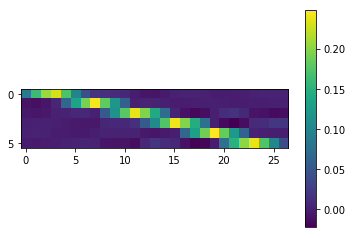

In [16]:
plt.imshow(GLOBALR)
plt.colorbar()

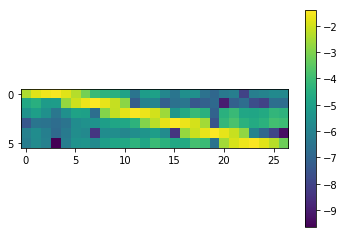

In [17]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

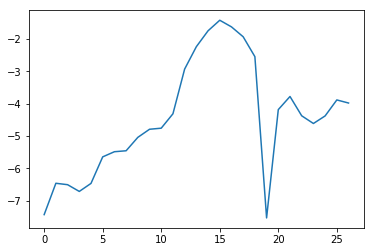

In [18]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
6.621788793213021
L2 norm: 
0.3645075125582699
H1 norm: 
4.9321856429841
Energy norm: 
0.5321093065774471
L2 norm: 
0.5154914678467866
H1 norm: 
0.5587046235678877
0.5545342457462381


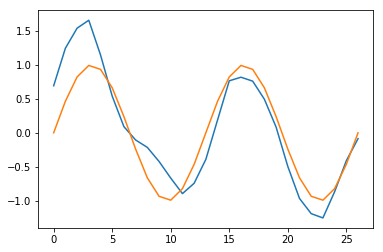

In [19]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)